# Table of Contents
 <p><div class="lev1"><a href="#Load-Variance-Problem"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Variance Problem</a></div><div class="lev2"><a href="#Import-Dependencies"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Dependencies</a></div><div class="lev2"><a href="#Construct-Problem"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Construct Problem</a></div><div class="lev2"><a href="#Higher-Load-Profile-Penality-$\gamma-=-10$"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Higher Load Profile Penality $\gamma = 10$</a></div><div class="lev3"><a href="#Map-Solution"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Map Solution</a></div><div class="lev3"><a href="#Results"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Results</a></div><div class="lev2"><a href="#Lower-Load-Profile-Penalty-$\gamma-=-0.5$"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Lower Load Profile Penalty $\gamma = 0.5$</a></div><div class="lev3"><a href="#Map-Solution"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Map Solution</a></div><div class="lev3"><a href="#Results"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Results</a></div><div class="lev4"><a href="#Energy-Price"><span class="toc-item-num">1.4.2.1&nbsp;&nbsp;</span>Energy Price</a></div><div class="lev1"><a href="#Plots"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plots</a></div><div class="lev2"><a href="#Load-Profile"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Profile</a></div><div class="lev2"><a href="#Battery"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Battery</a></div><div class="lev2"><a href="#Renewable-Power"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Renewable Power</a></div><div class="lev1"><a href="#Split-Problem-Into-Subproblem"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split Problem Into Subproblem</a></div><div class="lev1"><a href="#CVXPY-Distributed-Problem"><span class="toc-item-num">4&nbsp;&nbsp;</span>CVXPY Distributed Problem</a></div><div class="lev1"><a href="#Distributed-Gradient-Methods"><span class="toc-item-num">5&nbsp;&nbsp;</span>Distributed Gradient Methods</a></div><div class="lev2"><a href="#Check-Gradient"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Check Gradient</a></div><div class="lev1"><a href="#Distributed-Projected-Gradient-Descent"><span class="toc-item-num">6&nbsp;&nbsp;</span>Distributed Projected Gradient Descent</a></div><div class="lev2"><a href="#Projection-Step"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Projection Step</a></div><div class="lev2"><a href="#Map-Results"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Map Results</a></div><div class="lev2"><a href="#Show-Results"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Show Results</a></div><div class="lev1"><a href="#FOBOS"><span class="toc-item-num">7&nbsp;&nbsp;</span>FOBOS</a></div><div class="lev1"><a href="#Proximal-Gradient"><span class="toc-item-num">8&nbsp;&nbsp;</span>Proximal Gradient</a></div><div class="lev1"><a href="#Compare-Alogrithms"><span class="toc-item-num">9&nbsp;&nbsp;</span>Compare Alogrithms</a></div><div class="lev1"><a href="#Stochstic-Proximal-Gradient"><span class="toc-item-num">10&nbsp;&nbsp;</span>Stochstic Proximal Gradient</a></div><div class="lev1"><a href="#Numeric-Sensitivity-Computation"><span class="toc-item-num">11&nbsp;&nbsp;</span>Numeric Sensitivity Computation</a></div><div class="lev2"><a href="#Sensitivity-by-bounding-$H$"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Sensitivity by bounding $H$</a></div><div class="lev2"><a href="#Sensitivity-by-random-sampling-the-projection-operator"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Sensitivity by random sampling the projection operator</a></div>

# Load Variance Problem
## Import Dependencies

In [1]:
# Init Environment
# Autoreload Magic to autoreload external modules
%load_ext autoreload
%autoreload 2

# Numpy and Scipy
import numpy as np
import scipy
import scipy.io

from numpy import inf
from numpy.linalg import norm
from optalg.opt_solver import *

# Gridopt, PFNET and MP-PFNET
import pfnet
import mppfnet
import optalg
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import pfvis

# Python Multiprocessing
import multiprocessing

# Matplotlib and Seaborn
from matplotlib import rcParams
from matplotlib.pyplot import clf, plot, title, xlabel, ylabel, legend, show, spy
%matplotlib inline
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_formats=['retina']
import pylab
pylab.rcParams['figure.figsize'] =(16,6)

import seaborn

# CVXPY
import cvxpy

## Construct Problem

In [2]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

In [3]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]]) * mp.base_power 
mp.set_prices(eex_prices)

In [4]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

In [5]:
mp.generate_solar_profiles()

In [6]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

In [7]:
p = MPProblem(mp)

In [8]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

In [9]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN)

In [10]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

In [11]:
%aimport pfvis

pfvis.plot_graph(mp.get_network())

## Higher Load Profile Penality $\gamma = 10$

The state vector reads as:
$x = (x (0), \ldots, x(T))$

with $x(t) = (x_0 (t), \ldots, x_n (t))$

In [12]:
p.l.shape

(2160,)

In [13]:
x = cvxpy.Variable(mp.get_network().num_vars * mp.timesteps)

Tuning parameter $\gamma$ that scales the penalty of a spiky load profile. A lower $\gamma$ corresponds to a less spiky load profile.

In [14]:
gamma = 1

linear energy cost: $\sum_t^T \sum_i \bar f_i(t, x_i) = \sum_i c_i^\top x_i$

In [15]:
g = p.gphi #/ mp.base_power
cost_scaling_factor = np.maximum(norm(g, ord=inf), 1)
g = g / cost_scaling_factor
energy_cost_obj = g.T * x # energy cost

In [16]:
net_power = np.empty(mp.timesteps, dtype='object')
# the constant part of the power injection is the load and the vargen input
constant_powers = np.zeros((mp.timesteps, mp.get_network().num_buses - 1), dtype='object')
# expressions for the injected power at time t at bus i
power = np.empty(shape=(mp.timesteps, mp.get_network().num_buses - 1), dtype='object')
for t in range(0, mp.timesteps):
    for bus_i in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):        
        i = bus_i.index
        # constant parts of the injected power (load and vargens)
        constant_powers[t, i] = sum([load.P for load in mp.get_network(time=t).get_bus(i).loads])
        constant_powers[t, i] -= sum([ vargen.P for vargen in mp.get_network(time=t).get_bus(i).vargens]) # vargen power
        power_i_t  = constant_powers[t, i]
        # parts of the injected power that are optimization variables
        power_i_t  -= sum([x[t * mp.get_network().num_vars + gen.index_P] for gen in mp.get_network(time=t).get_bus(i).gens]) # gen power
        power_i_t  += sum([x[t * mp.get_network().num_vars + bat.index_Pc] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery charge
        power_i_t  -= sum([x[t * mp.get_network().num_vars + bat.index_Pd] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery discharge
        power[t, i] = power_i_t
    # the net power is the sum other all buses at a time t
    net_power[t] = sum(power[t, :])
   

the smoothing penality term is defined as:
$$\nu (x)  = \sum_{t}^{T} (p (t, x) - p(t-1, x))^2$$

with
$$p(t, x) = \sum_i p_i (t, x) = \sum_i (l_i (t) - r_i (t) - p_{g, i} (t, x) + p_{b, i} (t, x)) $$

In [17]:
profile_smothing_obj = sum([cvxpy.square(net_power[t] - net_power[t-1]) for t in range(1, mp.timesteps)])

Overall cost function:
$$f(x) = \gamma  \nu (x) + \sum_t^T \sum_i \bar f_i(t, x_i)$$

In [18]:
objective = cvxpy.Minimize(gamma * profile_smothing_obj + energy_cost_obj)

s.t.

battery dynamics $$A x = b$$

In [19]:
constraints = [p.A * x == p.b]

linear bounds $$l \le x \le u$$

In [20]:
constraints += [ p.l <= x, x <= p.u]

In [21]:
problem = cvxpy.Problem(objective, constraints)

In [22]:
_ = problem.solve()

Total penality for load profile spikes $\nu (x^*) = $ {{"{:.3}".format(profile_smothing_obj.value)}}

Total energy cost objective $\sum_t^T \bar f (x^*) = $ {{"{:.3}".format(energy_cost_obj.value * cost_scaling_factor)}}

### Map Solution

Save (centralized) solution as $x^*$ and update model

In [23]:
xstar = np.array(x.value).flatten()
pstar = objective.value
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

### Results

$p_b (t)$: power injected by the batteries

In [24]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [25]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [26]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [27]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [28]:
p_net  = np.fromiter([net_power[t] if isinstance(net_power[t], float) else net_power[t].value for t, net in mp.networks.items()], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

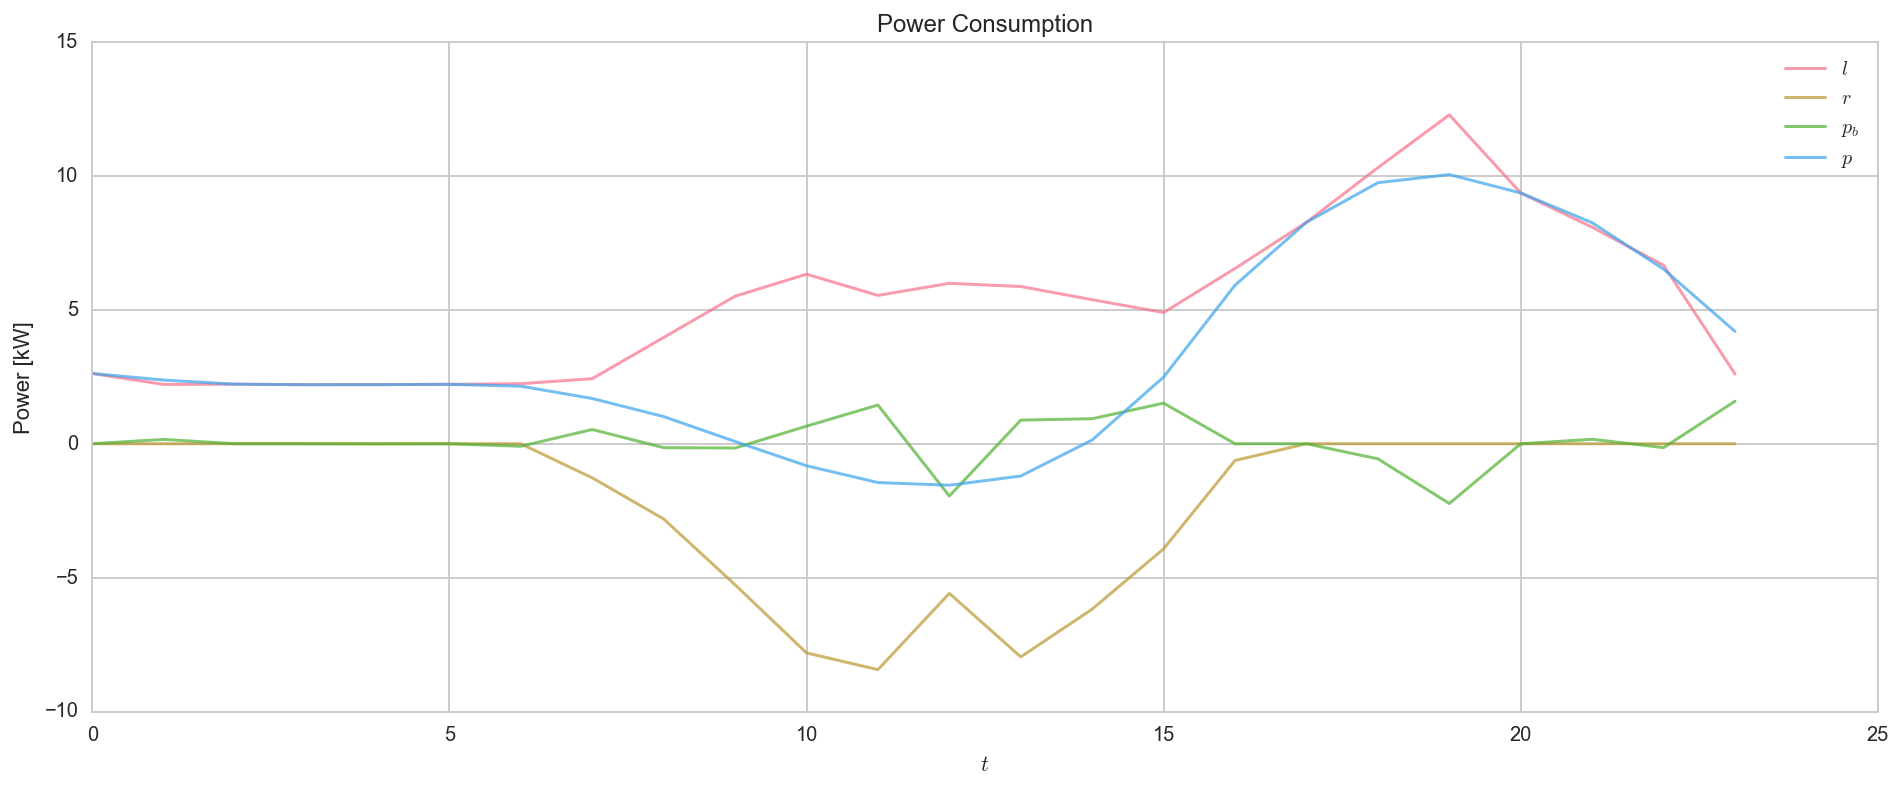

In [29]:
clf()
seaborn.set_style("whitegrid")

plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
show()

Energy Cost $f(x^*) =$ {{"{:.3}".format(energy_cost_obj.value * cost_scaling_factor)}}

Load profile penalty $\nu (x^*)= $ {{"{:.3}".format(profile_smothing_obj.value)}}

## Lower Load Profile Penalty $\gamma = 0.5$

In [30]:
gamma = 5e-1

In [31]:
objective = cvxpy.Minimize(gamma * profile_smothing_obj + energy_cost_obj)
problem_2 = cvxpy.Problem(objective, constraints)
_ = problem_2.solve()

Energy Cost $f(x^*) =$ {{"{:.3}".format(energy_cost_obj.value * cost_scaling_factor)}}

Load profile penalty $\nu (x^*)= $ {{"{:.3}".format(profile_smothing_obj.value)}}

### Map Solution

Save (centralized) solution as $x^*$ and update model

In [32]:
xstar = np.array(x.value).flatten()
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

###  Results

$p_b (t)$: power injected by the batteries

In [33]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [34]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [35]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [36]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [37]:
p_net  = np.fromiter([l[t] + r[t] + p_g[t] + p_b[t]  for t in range(mp.timesteps)], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

In [38]:
dp_net = np.fromiter([p_net[t] - p_net[t-1] for t in range(mp.timesteps)], np.float)

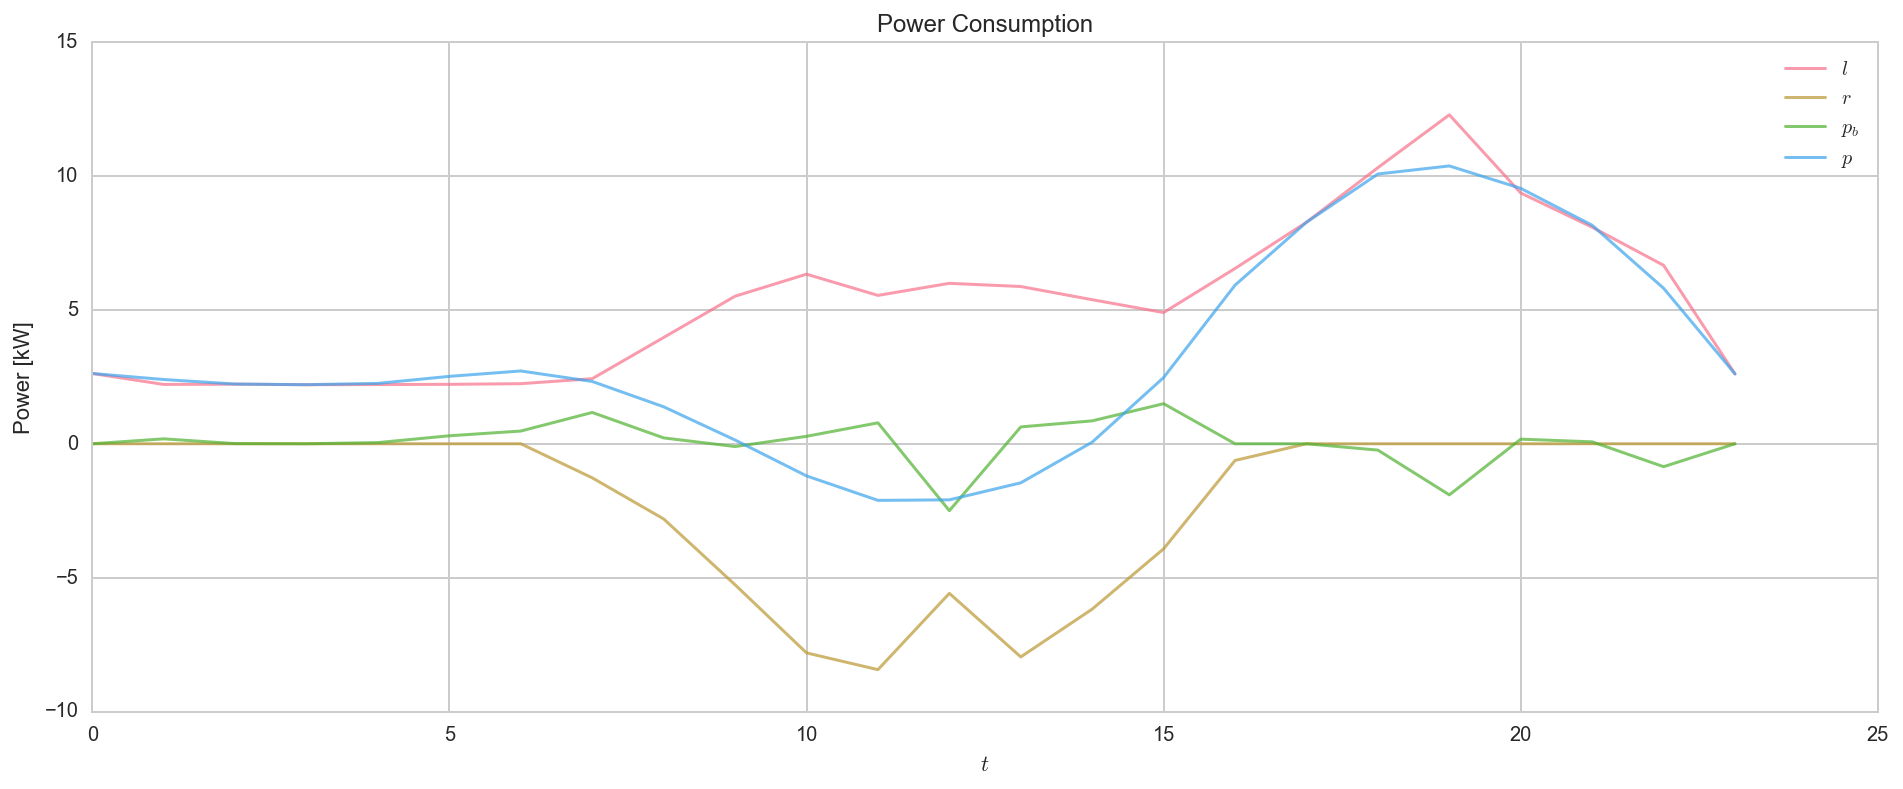

In [39]:
clf()
seaborn.set_style("whitegrid")

plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
#plot(dp_net, label="$\delta p$ ")
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
show()

#### Energy Price

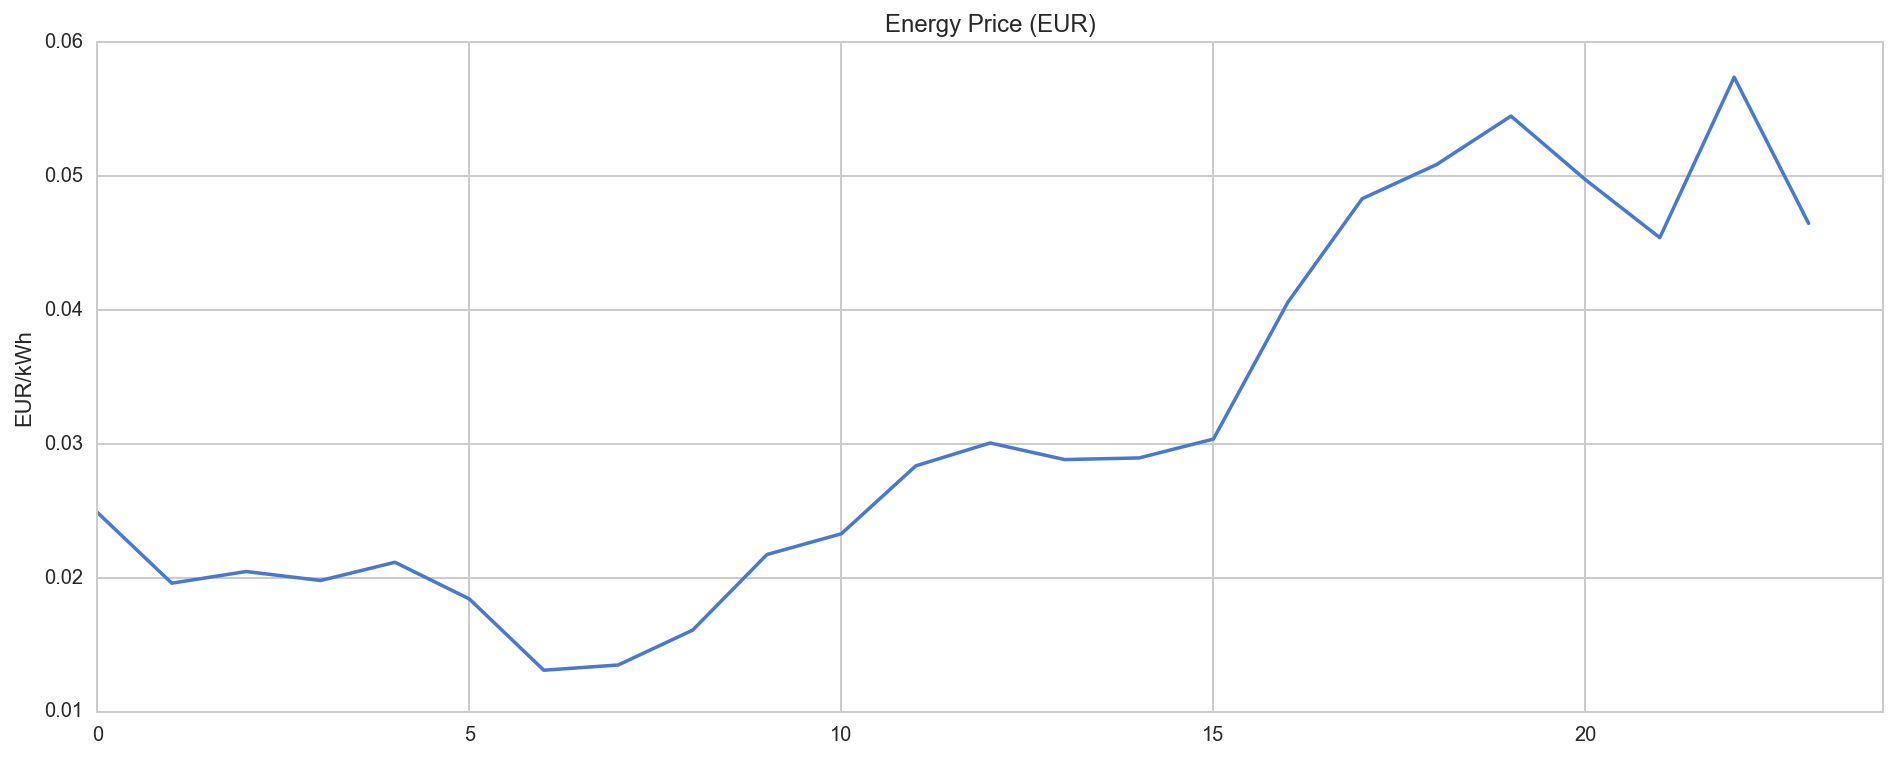

In [40]:
pfvis.plot_energy_price(mp)

# Plots

## Load Profile

In [41]:
%aimport pfvis
%aimport ipyplots

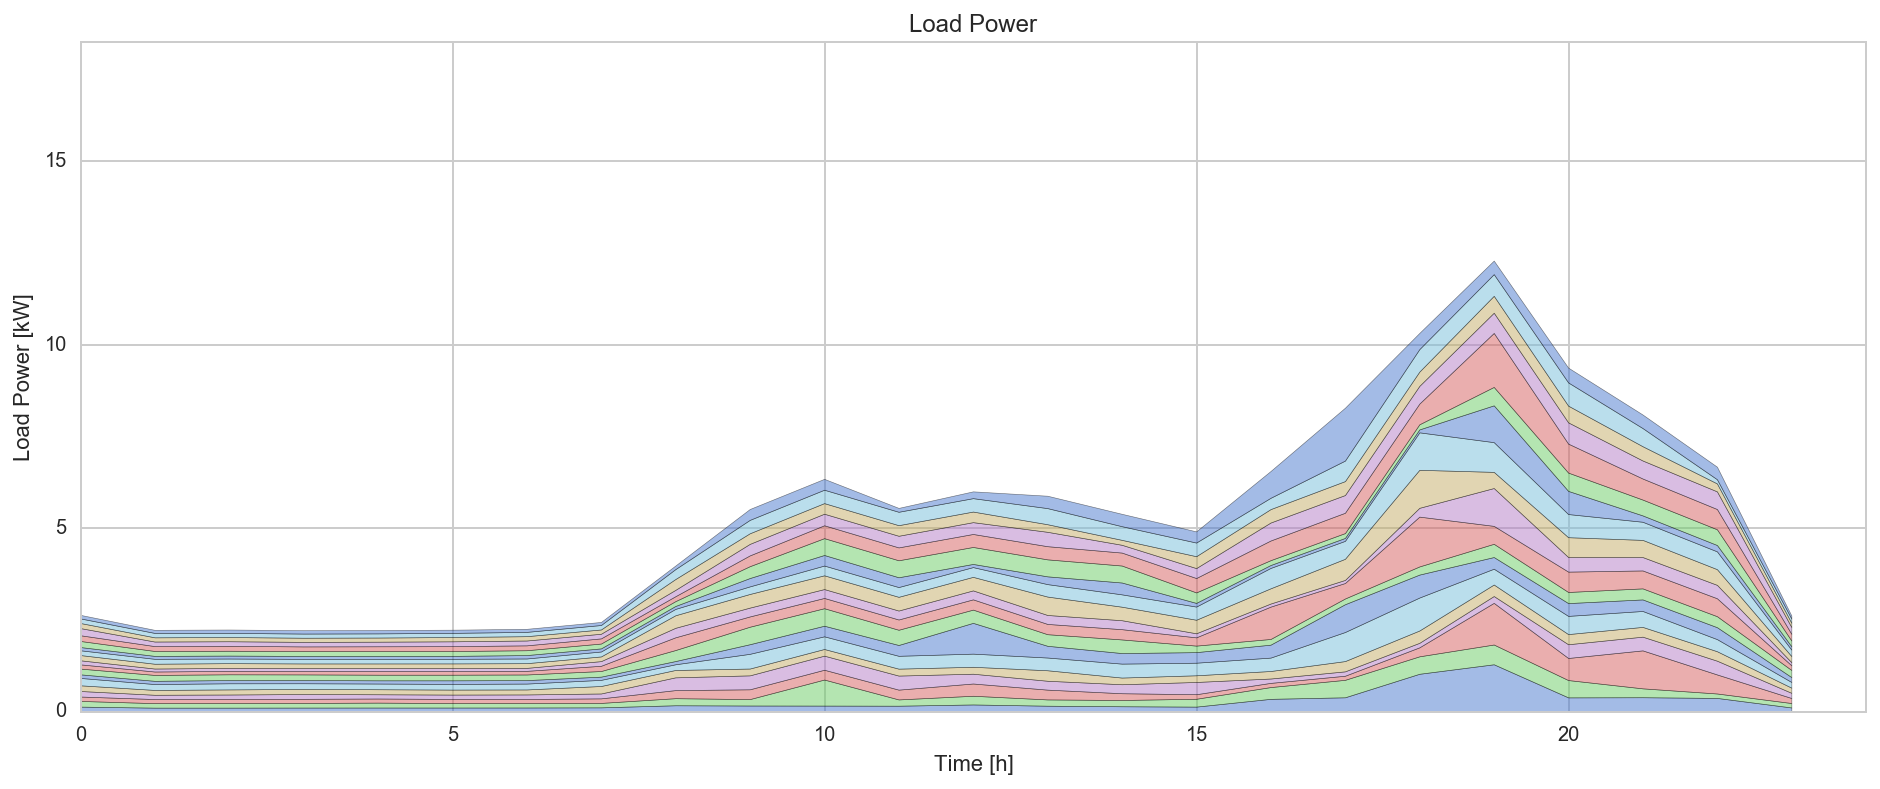

In [42]:
pfvis.plot_load_power(mp)

## Battery

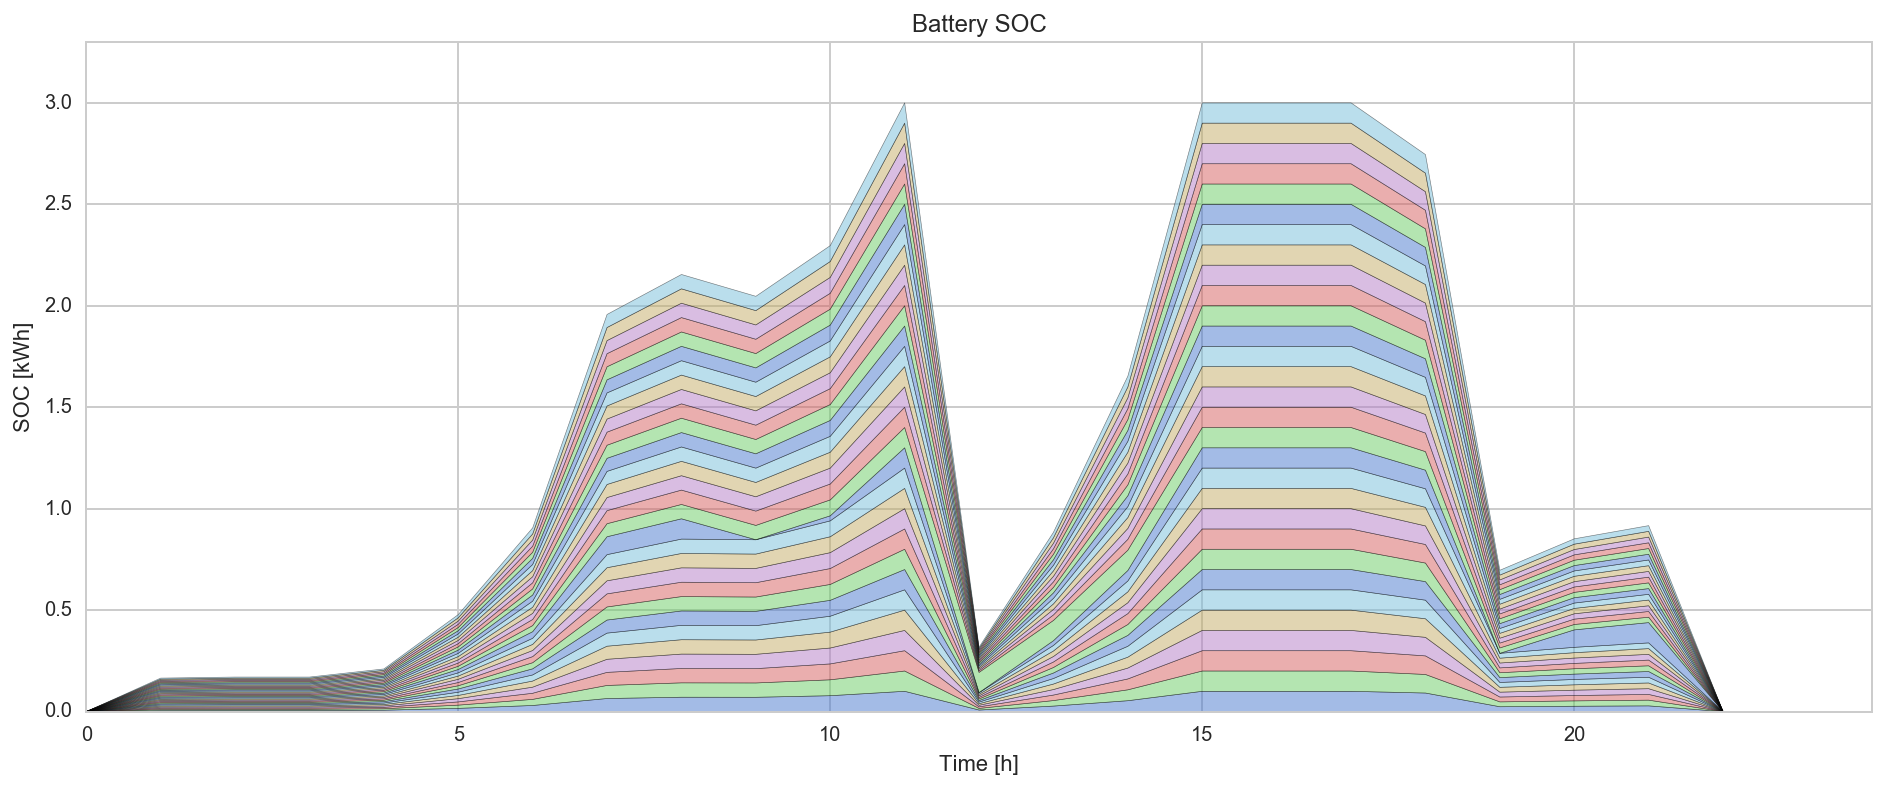

In [43]:
pfvis.plot_battery_soc(mp)

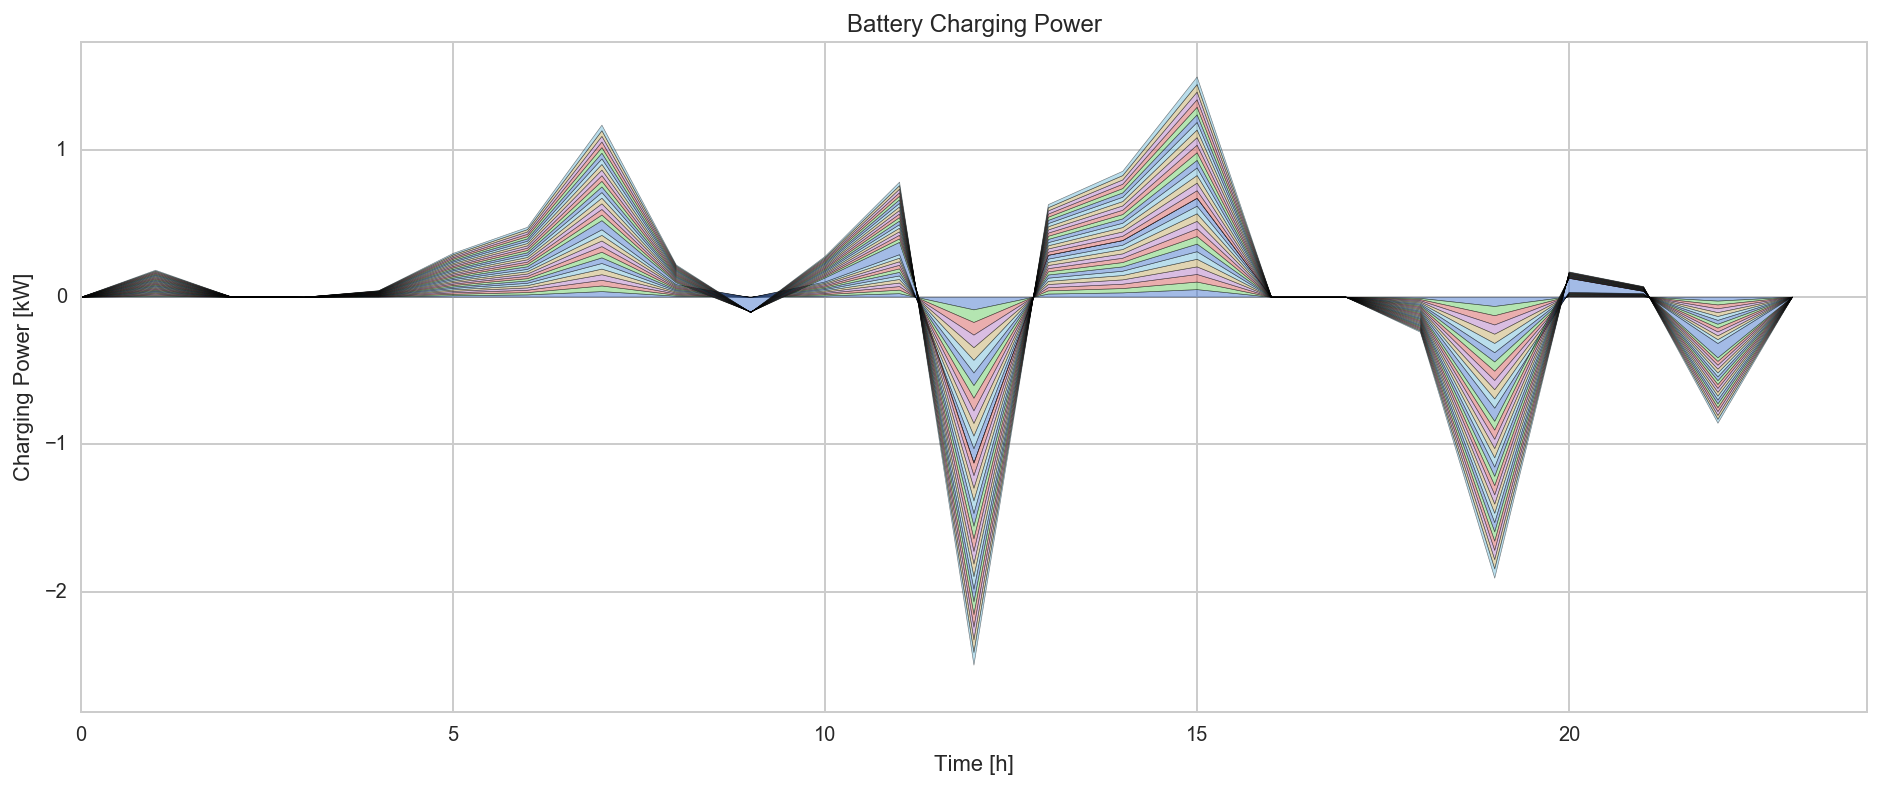

In [44]:
pfvis.plot_battery_power(mp)

## Renewable Power

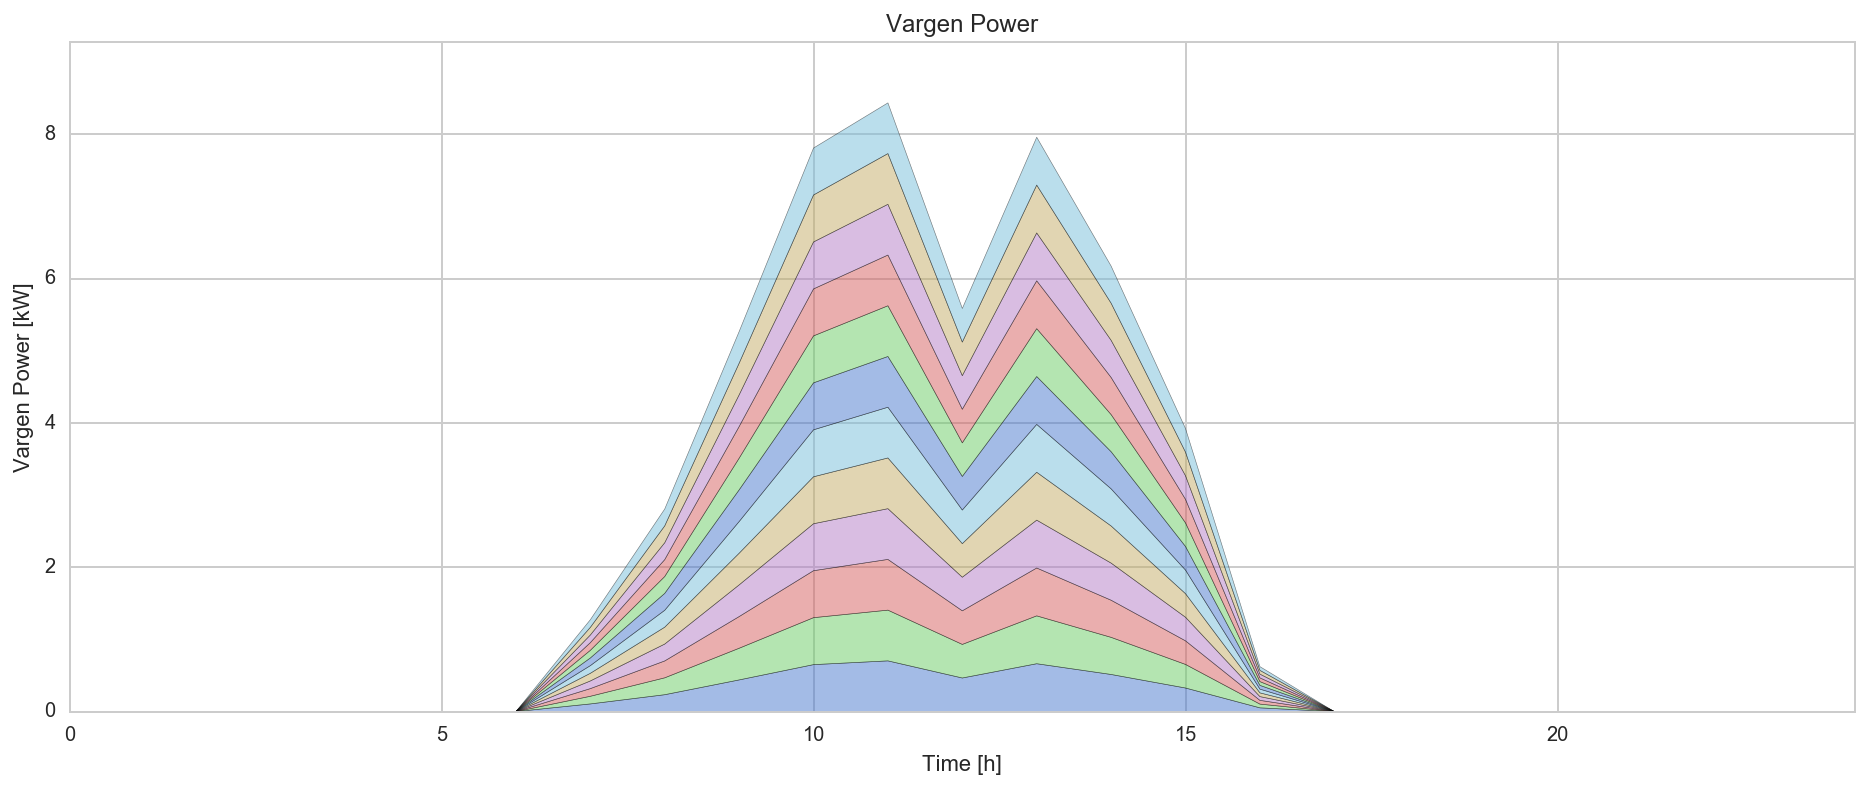

In [45]:
pfvis.plot_vargen_injection(mp)

# Split Problem Into Subproblem

Construct Projection Matrices

In [46]:
p_bats = {bus.index : mp.get_battery_var_projection(bus) for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)}

Construct battery constraints for the individual buses

In [47]:
net = mp.get_network()
a_bats = dict()

for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        a_bats[bus.index] = scipy.sparse.vstack([p.get_battery_A(bat) * p_bats[bus.index].T for bat in bus.bats])
    else:
        a_bats[bus.index] = scipy.sparse.coo_matrix(([], ([], [])), shape=(0, p_bats[bus.index].T.shape[1]))
b_bats = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        b_bats[bus.index] = np.hstack([p.get_battery_b(bat) for bat in bus.bats])   
    else:
        b_bats[bus.index] = np.array([])  

Construct linear bounds for the individual buses

In [48]:
l_mats = {bus.index: p_bats[bus.index] * p.l for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}
u_mats = {bus.index: p_bats[bus.index] * p.u for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

Construct (seperable) energy cost functions

In [49]:
g_mats = {bus.index: p_bats[bus.index] * g for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

# CVXPY Distributed Problem

Construct (seperable subproblems $0, \ldots, n$)

In [50]:
dist_problems = dict()
local_energy_cost_obj = np.zeros(mp.get_network().num_buses, dtype='object')
local_objective = np.zeros(mp.get_network().num_buses, dtype='object')
local_constraints = dict()

for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    i = bus.index
    num_var = g_mats[i].shape[0]
    x_i = p_bats[i] * x
    # check that x_i has the right dimensions
    assert(x_i.size[0] == num_var)
    
    # local constraints
    local_constraints[i] = [l_mats[i] <= x_i, x_i <= u_mats[i], a_bats[i] * x_i == b_bats[i]]
    
    # local objective
    local_energy_cost_obj[i] = g_mats[i].T * x_i 
    local_objective[i] = cvxpy.Minimize( local_energy_cost_obj[i])
    
    dist_problems[i] = cvxpy.Problem(local_objective[i], local_constraints[i])

Create problem with non-seperable objective (the load profile penalty)

In [51]:
non_seperable = cvxpy.Problem(cvxpy.Minimize(gamma * profile_smothing_obj))

Solve sum of problems

In [52]:
prob = (sum([prob for prob in dist_problems.values()]) + non_seperable)
prob.solve()
pstar = prob.objective.value

# Distributed Gradient Methods

Check if there exists a $t \in \{0, \ldots, T \}$ s.t. $P_{c, i} (t) > 0 \land P_{d, i} (t) > 0$ 

In [53]:
D_s = np.matrix(scipy.vstack([np.array([0, 0, 0] * t + [1, -1, 0, -1, 1, 0] + [0, 0, 0] * (mp.timesteps - t - 2), ndmin=2) for t in range(mp.timesteps - 1)]))

In [54]:
D_c = np.matrix(scipy.vstack([np.array([0] * t + [1, -1] + [0] * (mp.timesteps - t - 2), ndmin=2) for t in range(mp.timesteps - 1)]))

Constant Power: $$c_i = \left( l_i (0) - r_i (0), \ldots, l_i (T) - r_i (T) \right)$$

In [55]:
c = dict()
for bus_i in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    i = bus_i.index
    c[i] = np.matrix(np.fromiter((constant_powers[t, i] for t in range(mp.timesteps)), dtype=float)).T

$$d_c = \sum_{i \in \Omega_b} D_c c_i$$

In [56]:
d_c = sum([D_c * c[bus.index] for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)]).A.flatten()

$$d_s (x) = \sum_{i \in \Omega_b} D_s P_{b, i} x$$
with $\Omega_b$ is the set of buses excluding the slack bus and $P_{b,i}$ the projection variable extracting the variables related to bus $i$.

In [79]:
def d_s(x):
    return np.dot(D_s, sum([(p_bats[bus.index] * x) for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)])).A.flatten()

Cost function $$h(x) = \gamma (d_c^\top d_c + 2 d_c^\top d_s (x) + d_s (x)^\top d_s (x)) + g^\top x$$

In [80]:
def h(x):
    return gamma * (np.dot(d_c,d_c) + 2 * np.dot(d_c, d_s(x)) + np.dot(d_s(x), d_s(x))) + (np.dot(g, x))

Gradient of $h(x)$ at bus $i$
$$ \nabla h_i (x) = \gamma ( 2 d_c^\top D_s + 2 d_s(x)^\top D_s) + P_{b, i} g \\
= 2 \gamma ( d_c + d_s(x))^\top D_s  + P_{b, i} g$$

In [120]:
def grad_h(x, bus=None):
    if bus is not None:
        return gamma* (2 * d_c.dot(D_s) + 2 * d_s(x).dot(D_s)).A.flatten() + p_bats[bus.index] * g
    else:
        return gamma* sum([p_bat.T * (2 * d_c.dot(D_s).A.flatten() + 2 * d_s(x).dot(D_s).A.flatten()) for p_bat in p_bats.values()]) + g

## Check Gradient

In [121]:
a_1 = scipy.optimize.approx_fprime(xstar, h, 1e-8)

Relative Error of the gradient in percent

In [122]:
rel_grad_err = np.max(100 * np.abs(a_1 - grad_h(xstar)) / np.maximum(np.abs(grad_h(xstar)), 1e-5))

Relative Gradient Error: $100 \cdot \frac{\max{|a_1 - \Delta h (x^*)|}}{\max{(|\Delta h (x^*)|, 10^{-5}})} = $  {{"{:.3}".format(rel_grad_err)}}

In [123]:
from IPython.display import display, Markdown, clear_output, Math
from pylab import plt
class OptOutput():
    def __init__(self, title, iterations, keys, label="", plot_excluded=["k", "alpha", "ld"]):
        
        self.plot_excluded = plot_excluded
        
        self.title = title
        self.iterations = iterations
        self.figure, self.axis = plt.subplots(2, 1)
        self.figure.canvas.set_window_title(self.title)
        self.colors = seaborn.color_palette()
        self.keys = keys
        self.figure.tight_layout()

        # Data
        self.values = {key: [] for key in keys}
        
        for i, key in enumerate(filter(lambda key: not (key in self.plot_excluded), keys)):
            if key == "h(x) - h(x*)":
                self.axis[0].plot(self.values[key], label=key, color=self.colors[i])
            else:
                self.axis[1].plot(self.values[key], label=key, color=self.colors[i])

        self.axis[0].legend()
        self.axis[1].legend()
        
        self.axis[0].set_ylabel(label)
        self.axis[0].set_xlabel("k")
        self.axis[1].set_xlabel("k")

        
        self.axis[0].set_title(title)
        self.axis[0].set_xlim(0, self.iterations)  
        self.axis[1].set_xlim(0, self.iterations)  
        
        self.axis[0].set_ylim(1e-7, 1e1)    
        self.axis[1].set_ylim(0, 6)    

        
        self.axis[0].set_yscale('log')
        #self.figure.canvas.draw()
        
        self.output =  "| " + "|".join(keys) +  " |\n"
        self.output += "| " +  "|".join(["---"] * len(keys)) + "|\n"
        display(Markdown(self.output))
        
    def update_values(self, values):
        iteration = values["k"]
        plot_x = np.arange(0, iteration+1)
        i = 0
        for key in filter(lambda key: not (key in self.plot_excluded), self.keys):
            self.values[key].append(values[key])
            if key == "h(x) - h(x*)":        
                self.axis[0].lines[0].set_xdata(plot_x)
                self.axis[0].lines[0].set_ydata(self.values[key]) 
            else:
                self.axis[1].lines[i].set_xdata(plot_x)
                self.axis[1].lines[i].set_ydata(self.values[key]) 
                i += 1

        #self.figure.canvas.draw()      
        if iteration % 10 == 0:
            self.output += "| " + "|".join([("{}"if isinstance(values[key], int) else "{:.2E}").format(values[key]) for key in self.keys]) + "|\n"
            plt.draw()
            clear_output(wait=True)            
            display(Markdown(self.output), self.figure)

# Distributed Projected Gradient Descent

## Projection Step

In [125]:
def global_proj_x(xbar):
    x_s = cvxpy.Variable(len(xbar))
    x_s.value = xbar
    proj_obj = cvxpy.Minimize(cvxpy.norm(xbar - x_s))
    proj_constr = [p.l <= x_s, x_s <= p.u, p.A * x_s == p.b]
    proj_prob = cvxpy.Problem(proj_obj, proj_constr)
    proj_prob.solve(solver=cvxpy.ECOS, max_iters=10000)
    return x_s.value.A.flatten()
    
    #prob = optalg.opt_solver.QuadProblem(scipy.sparse.eye(len(xbar)), -xbar, p.A, p.b, p.l, p.u, x=xbar)
    #solver =optalg.opt_solver.OptSolverIQP()
    #solver.set_parameters({'quiet' : True, 'tol' : 1e-8})    
    #solver.solve(prob)
    #return solver.get_primal_variables()

In [126]:
def proj_x(xbar, i):
    
    # Solve with OPTALG
    
    #prob = optalg.opt_solver.QuadProblem(scipy.sparse.eye(len(xbar)), -xbar, a_bats[i], b_bats[i], l_mats[i], u_mats[i], x=xbar)    
    #solver =optalg.opt_solver.OptSolverIQP()
    #solver.set_parameters({'quiet' : True, 'tol' : 1e-4})    
    #solver.solve(prob)

    #return solver.get_primal_variables()
    
    # Solve with CVXPY (ECOS)
    x_s = cvxpy.Variable(len(xbar))
    proj_obj = cvxpy.Minimize(cvxpy.norm(xbar - x_s))
    proj_constr = [l_mats[i] <= x_s, x_s <= u_mats[i], a_bats[i] * x_s == b_bats[i]]
    proj_prob = cvxpy.Problem(proj_obj, proj_constr)
    proj_prob.solve()
    return x_s.value.A.flatten()

| k|h(x)|h(x) - h(x*)|h(x*)|dh|alpha |
| ---|---|---|---|---|---|
| 0|1.63E+00|1.45E+00|1.87E-01|1.28E+00|1.00E+00|
| 10|3.90E+00|3.71E+00|1.87E-01|2.06E+00|9.09E-02|
| 20|3.62E+00|3.44E+00|1.87E-01|2.06E+00|4.76E-02|
| 30|4.20E+00|4.01E+00|1.87E-01|2.06E+00|3.23E-02|
| 40|3.73E+00|3.55E+00|1.87E-01|1.56E+00|2.44E-02|
| 50|3.53E+00|3.34E+00|1.87E-01|1.56E+00|1.96E-02|
| 60|3.26E+00|3.07E+00|1.87E-01|1.56E+00|1.64E-02|
| 70|2.72E+00|2.53E+00|1.87E-01|1.52E+00|1.41E-02|
| 80|1.55E+00|1.36E+00|1.87E-01|1.30E+00|1.23E-02|
| 90|2.76E-01|8.93E-02|1.87E-01|6.59E-01|1.10E-02|
| 100|2.17E-01|2.98E-02|1.87E-01|6.58E-01|9.90E-03|
| 110|2.08E-01|2.08E-02|1.87E-01|6.59E-01|9.01E-03|
| 120|2.04E-01|1.70E-02|1.87E-01|6.59E-01|8.26E-03|
| 130|2.01E-01|1.35E-02|1.87E-01|6.59E-01|7.63E-03|
| 140|1.98E-01|1.04E-02|1.87E-01|6.59E-01|7.09E-03|
| 150|1.95E-01|7.63E-03|1.87E-01|6.59E-01|6.62E-03|
| 160|1.93E-01|6.19E-03|1.87E-01|6.59E-01|6.21E-03|
| 170|1.92E-01|4.99E-03|1.87E-01|6.59E-01|5.85E-03|
| 180|1.91E-01|3.88E-03|1.87E-01|6.59E-01|5.52E-03|
| 190|1.90E-01|2.83E-03|1.87E-01|6.59E-01|5.24E-03|
| 200|1.89E-01|1.85E-03|1.87E-01|6.59E-01|4.98E-03|
| 210|1.88E-01|9.08E-04|1.87E-01|6.59E-01|4.74E-03|
| 220|1.87E-01|1.78E-04|1.87E-01|6.59E-01|4.52E-03|
| 230|1.87E-01|1.34E-04|1.87E-01|6.59E-01|4.33E-03|
| 240|1.87E-01|1.05E-04|1.87E-01|6.59E-01|4.15E-03|
| 250|1.87E-01|9.43E-05|1.87E-01|6.59E-01|3.98E-03|
| 260|1.87E-01|8.97E-05|1.87E-01|6.59E-01|3.83E-03|
| 270|1.87E-01|8.61E-05|1.87E-01|6.59E-01|3.69E-03|
| 280|1.87E-01|8.30E-05|1.87E-01|6.59E-01|3.56E-03|
| 290|1.87E-01|8.03E-05|1.87E-01|6.59E-01|3.44E-03|


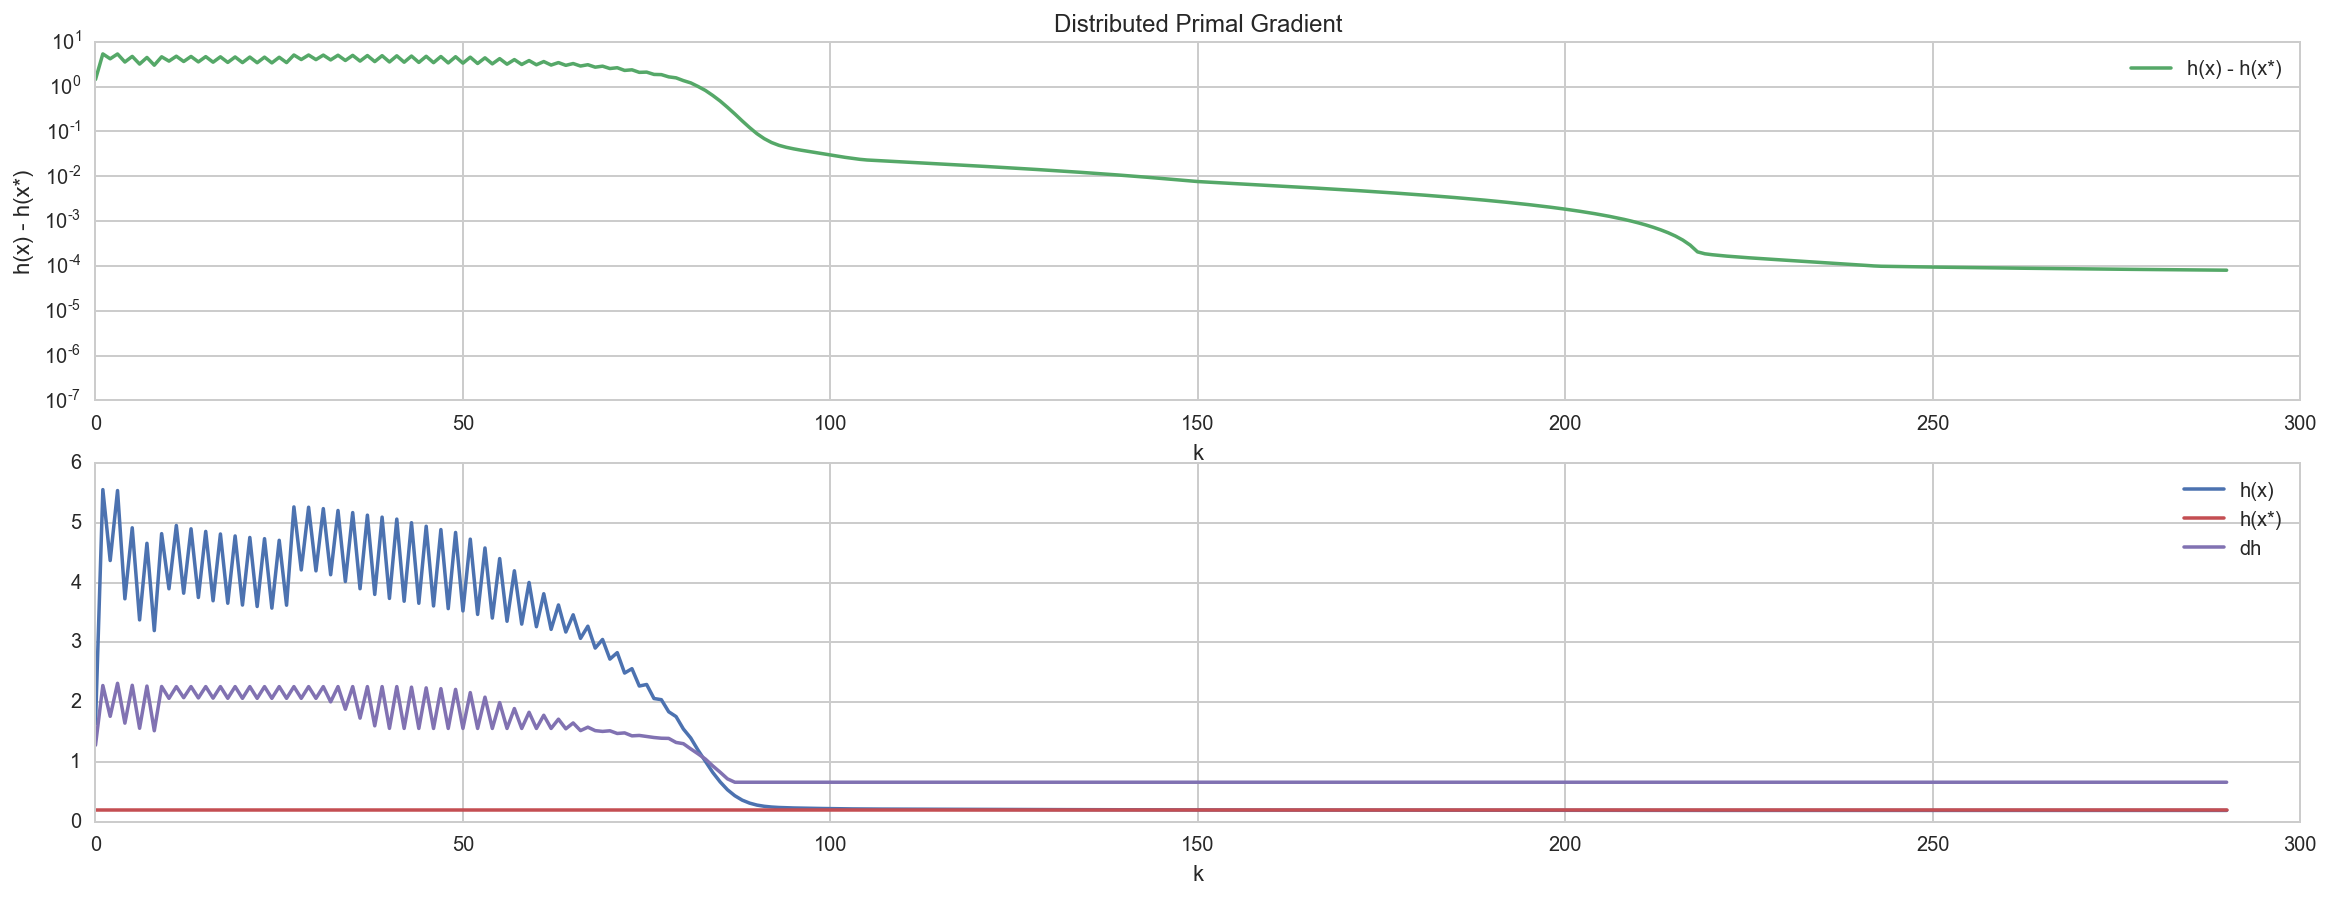

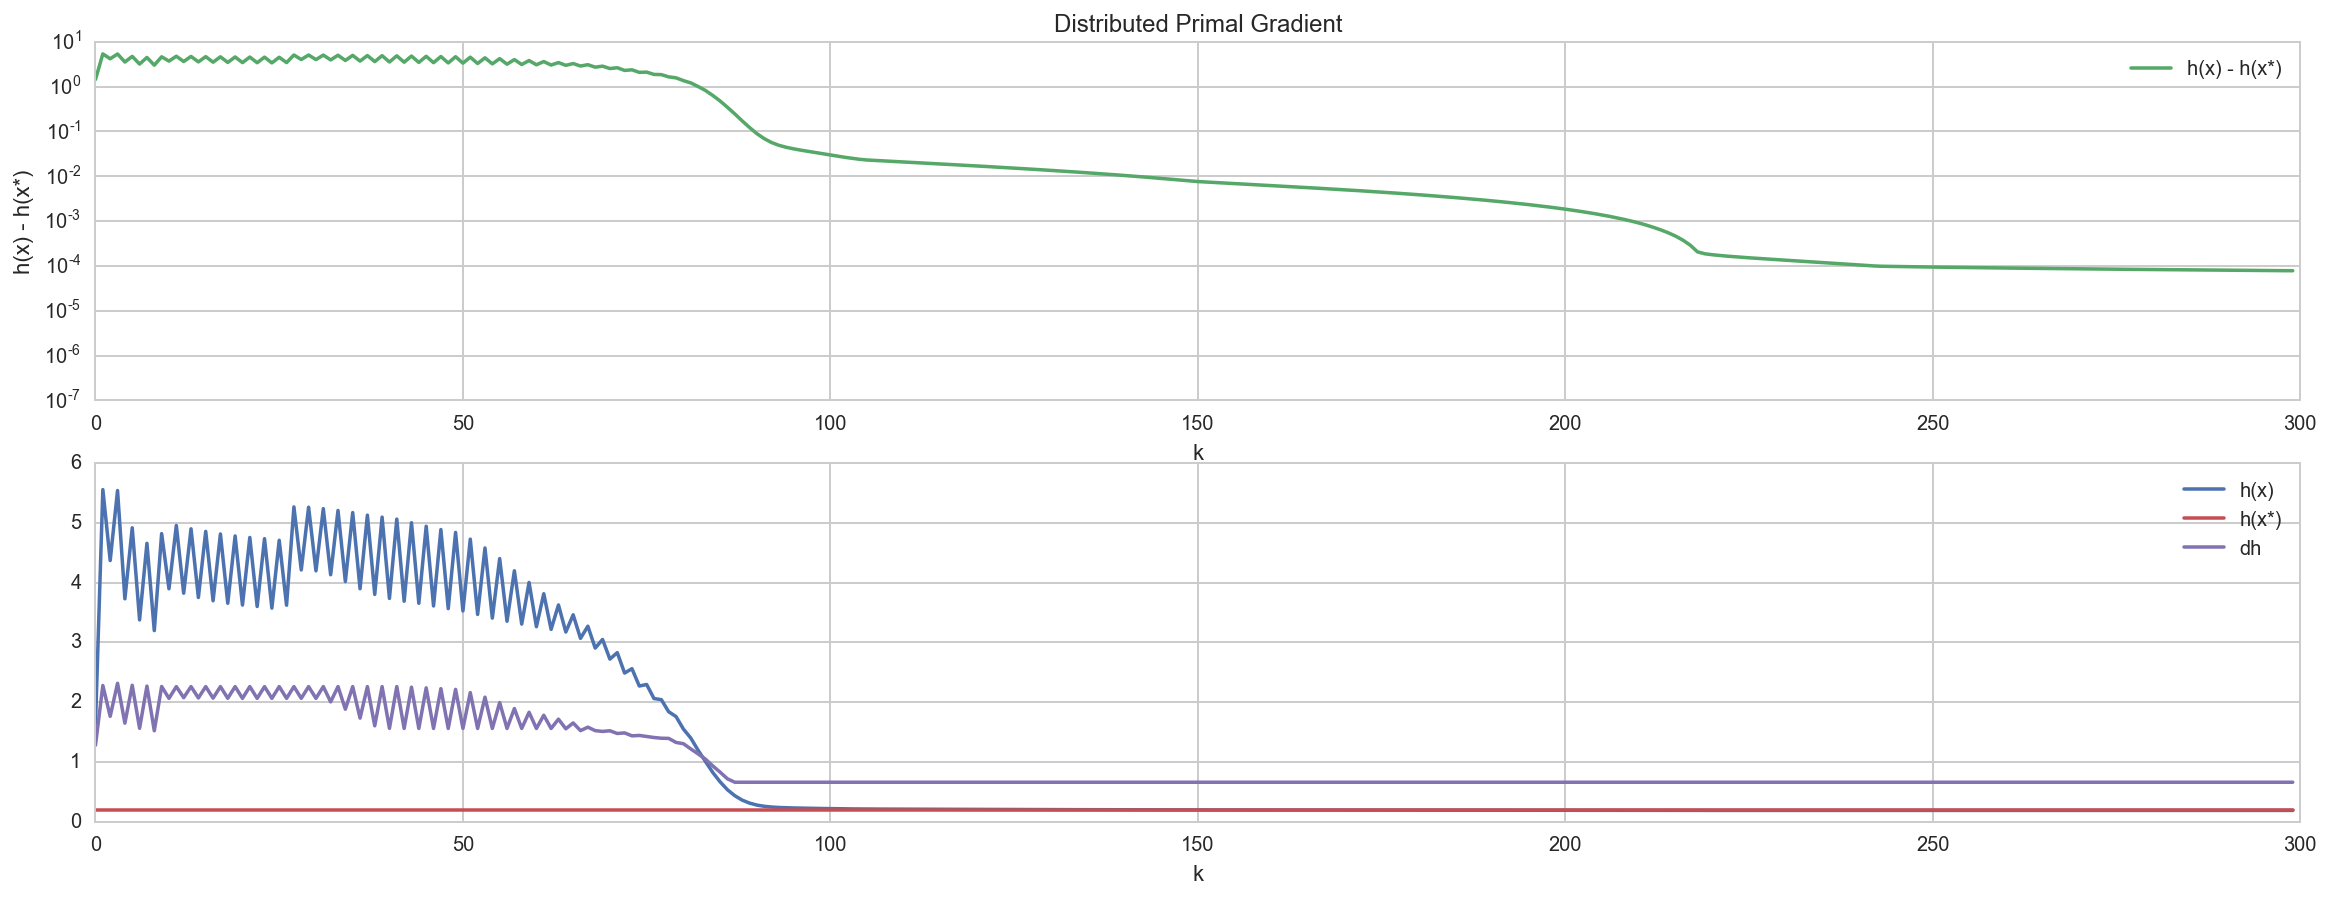

In [127]:
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

max_iteration = 300

dpg_output = OptOutput("Distributed Primal Gradient", max_iteration,
                   ["k", "h(x)", "h(x) - h(x*)","h(x*)", "dh", "alpha"], label="h(x) - h(x*)")


for k in range(max_iteration):
    alpha = 1 / (k + 1)
    
    xstep = np.zeros(xsol.shape)
    
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(proj_x, [(p_bats[bus.index] * xsol - alpha * grad_h(xsol, bus=bus),
                                       bus.index) for bus in buses_wo_slack])

    xpre = xsol.copy()
    xsol = sum([p_bats[i].T * step for i, step in enumerate(steps)])
        
    # Output
    dpg_output.update_values({"k" : k, "h(x)" : h(xsol), "h(x) - h(x*)" : h(xsol)- h(xstar),
                          "h(x*)" : h(xstar), "dh" : norm(grad_h(xsol), ord=inf), "alpha": alpha})
    
    # check convergence
    #if norm(xsol - xpre, ord=inf) < 1e-5:
    #    print('Converged')
    #    break

In [128]:
psol = h(xsol)

Difference in objective value compared to CVXPY

## Map Results

In [129]:
mp.set_var_values(xsol)
mp.update_properties()

## Show Results

$p_b (t)$: power injected by the batteries

In [130]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [131]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [132]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [133]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [134]:
p_net  = np.fromiter([l[t] + r[t] + p_g[t] + p_b[t]  for t in range(mp.timesteps -1)], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

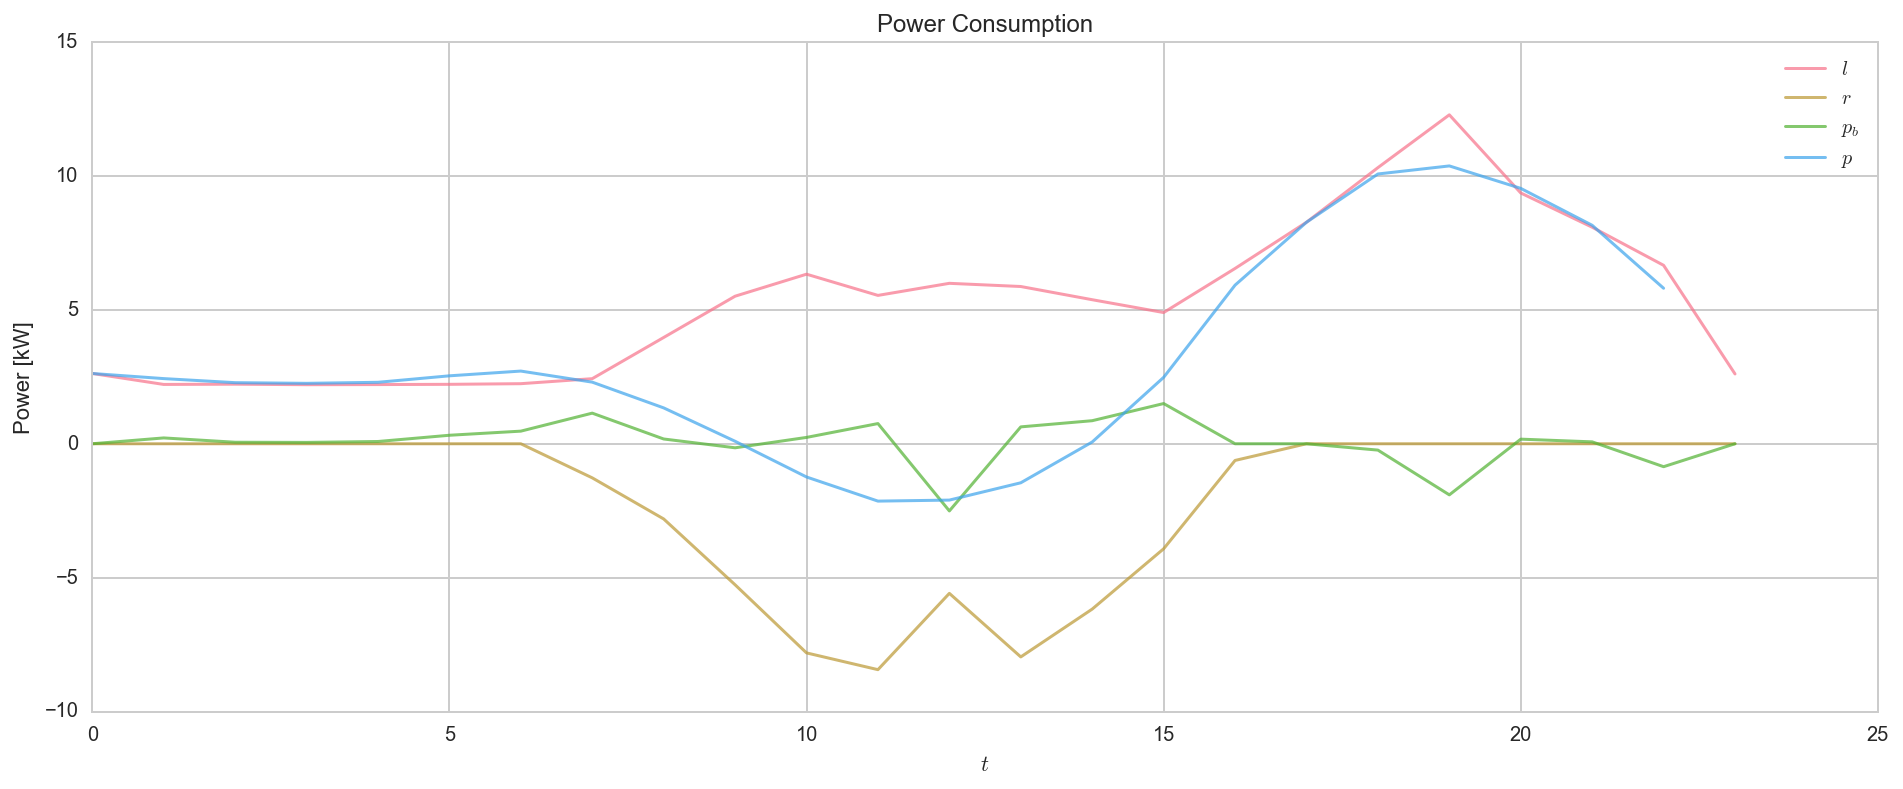

In [135]:
fig, ax = plt.subplots(1,1)

seaborn.set_style("whitegrid")

ax.plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
ax.plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
ax.plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
ax.plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
fig.canvas.draw()

In [136]:
print("{:.2E}".format(h(xsol)))

1.87E-01


# FOBOS

Cost function $f(x)$(the load profile smoothing term)

In [137]:
def f(x):
    return gamma * (np.dot(d_c,d_c) + 2 * np.dot(d_c, d_s(x)) + np.dot(d_s(x), d_s(x)))

Gradient of $f(x)$ (the load profile smoothing term)

In [138]:
def grad_f(x, bus=None):
    if bus is not None:
        return gamma* (2 * D_s.T.dot(d_c).A.flatten() + 2 * D_s.T.dot(d_s(x)).A.flatten())
    else:
        return gamma* sum([p_bat.T * (2 * D_s.T.dot(d_c).A.flatten() + 2 * D_s.T.dot(d_s(x)).A.flatten()) for p_bat in p_bats.values()])

proximal operator

$$ \text{argmin} \frac 1 2 \left||{x - \bar x}\right||^2_2 + \eta g^\top x$$
s.t. $$A x = b \\ l \le x \le u$$


$$\text{prox}_r (x)$$
with
$$ r(x) = \eta g^\top x $$
$$\mathrm{dom}(r(x)) = \left\{ x | A x  = b, l \le x \le u \right\}$$

In [139]:
def prox_step(xbar, i, alpha):
    eta = alpha
    x_s = cvxpy.Variable(len(xbar))
    proj_obj = cvxpy.Minimize(0.5 * cvxpy.sum_squares(x_s - xbar) + eta * g_mats[i] * x_s)
    proj_constr = [l_mats[i] <= x_s, x_s <= u_mats[i], a_bats[i] * x_s == b_bats[i]]
    proj_prob = cvxpy.Problem(proj_obj, proj_constr)
    proj_prob.solve()
    return x_s.value.A.flatten()

$$x^{k+1} = \text{prox}_r (x^{k} - \alpha \Delta f)$$

In [140]:
max_iteration = 300

| k|h(x)|h(x) - h(x*)|h(x*)|df|alpha |
| ---|---|---|---|---|---|
| 0|1.63E+00|1.45E+00|1.87E-01|1.28E+00|1.00E+00|
| 10|3.90E+00|3.71E+00|1.87E-01|1.49E+00|9.09E-02|
| 20|3.62E+00|3.44E+00|1.87E-01|1.49E+00|4.76E-02|
| 30|4.20E+00|4.01E+00|1.87E-01|1.49E+00|3.23E-02|
| 40|3.73E+00|3.55E+00|1.87E-01|1.37E+00|2.44E-02|
| 50|3.52E+00|3.34E+00|1.87E-01|1.36E+00|1.96E-02|
| 60|3.26E+00|3.07E+00|1.87E-01|1.35E+00|1.64E-02|
| 70|2.72E+00|2.53E+00|1.87E-01|1.34E+00|1.41E-02|
| 80|1.55E+00|1.36E+00|1.87E-01|1.12E+00|1.23E-02|
| 90|2.76E-01|8.93E-02|1.87E-01|3.20E-01|1.10E-02|
| 100|2.17E-01|2.98E-02|1.87E-01|3.20E-01|9.90E-03|
| 110|2.08E-01|2.08E-02|1.87E-01|3.20E-01|9.01E-03|
| 120|2.04E-01|1.70E-02|1.87E-01|3.20E-01|8.26E-03|
| 130|2.01E-01|1.35E-02|1.87E-01|3.20E-01|7.63E-03|
| 140|1.98E-01|1.04E-02|1.87E-01|3.20E-01|7.09E-03|
| 150|1.95E-01|7.62E-03|1.87E-01|3.20E-01|6.62E-03|
| 160|1.93E-01|6.19E-03|1.87E-01|3.20E-01|6.21E-03|
| 170|1.92E-01|4.99E-03|1.87E-01|3.20E-01|5.85E-03|
| 180|1.91E-01|3.88E-03|1.87E-01|3.20E-01|5.52E-03|
| 190|1.90E-01|2.83E-03|1.87E-01|3.20E-01|5.24E-03|
| 200|1.89E-01|1.85E-03|1.87E-01|3.20E-01|4.98E-03|
| 210|1.88E-01|9.08E-04|1.87E-01|3.20E-01|4.74E-03|
| 220|1.87E-01|1.77E-04|1.87E-01|3.20E-01|4.52E-03|
| 230|1.87E-01|1.33E-04|1.87E-01|3.20E-01|4.33E-03|
| 240|1.87E-01|1.04E-04|1.87E-01|3.20E-01|4.15E-03|
| 250|1.87E-01|9.36E-05|1.87E-01|3.20E-01|3.98E-03|
| 260|1.87E-01|8.92E-05|1.87E-01|3.20E-01|3.83E-03|
| 270|1.87E-01|8.56E-05|1.87E-01|3.20E-01|3.69E-03|
| 280|1.87E-01|8.25E-05|1.87E-01|3.20E-01|3.56E-03|
| 290|1.87E-01|8.00E-05|1.87E-01|3.20E-01|3.44E-03|


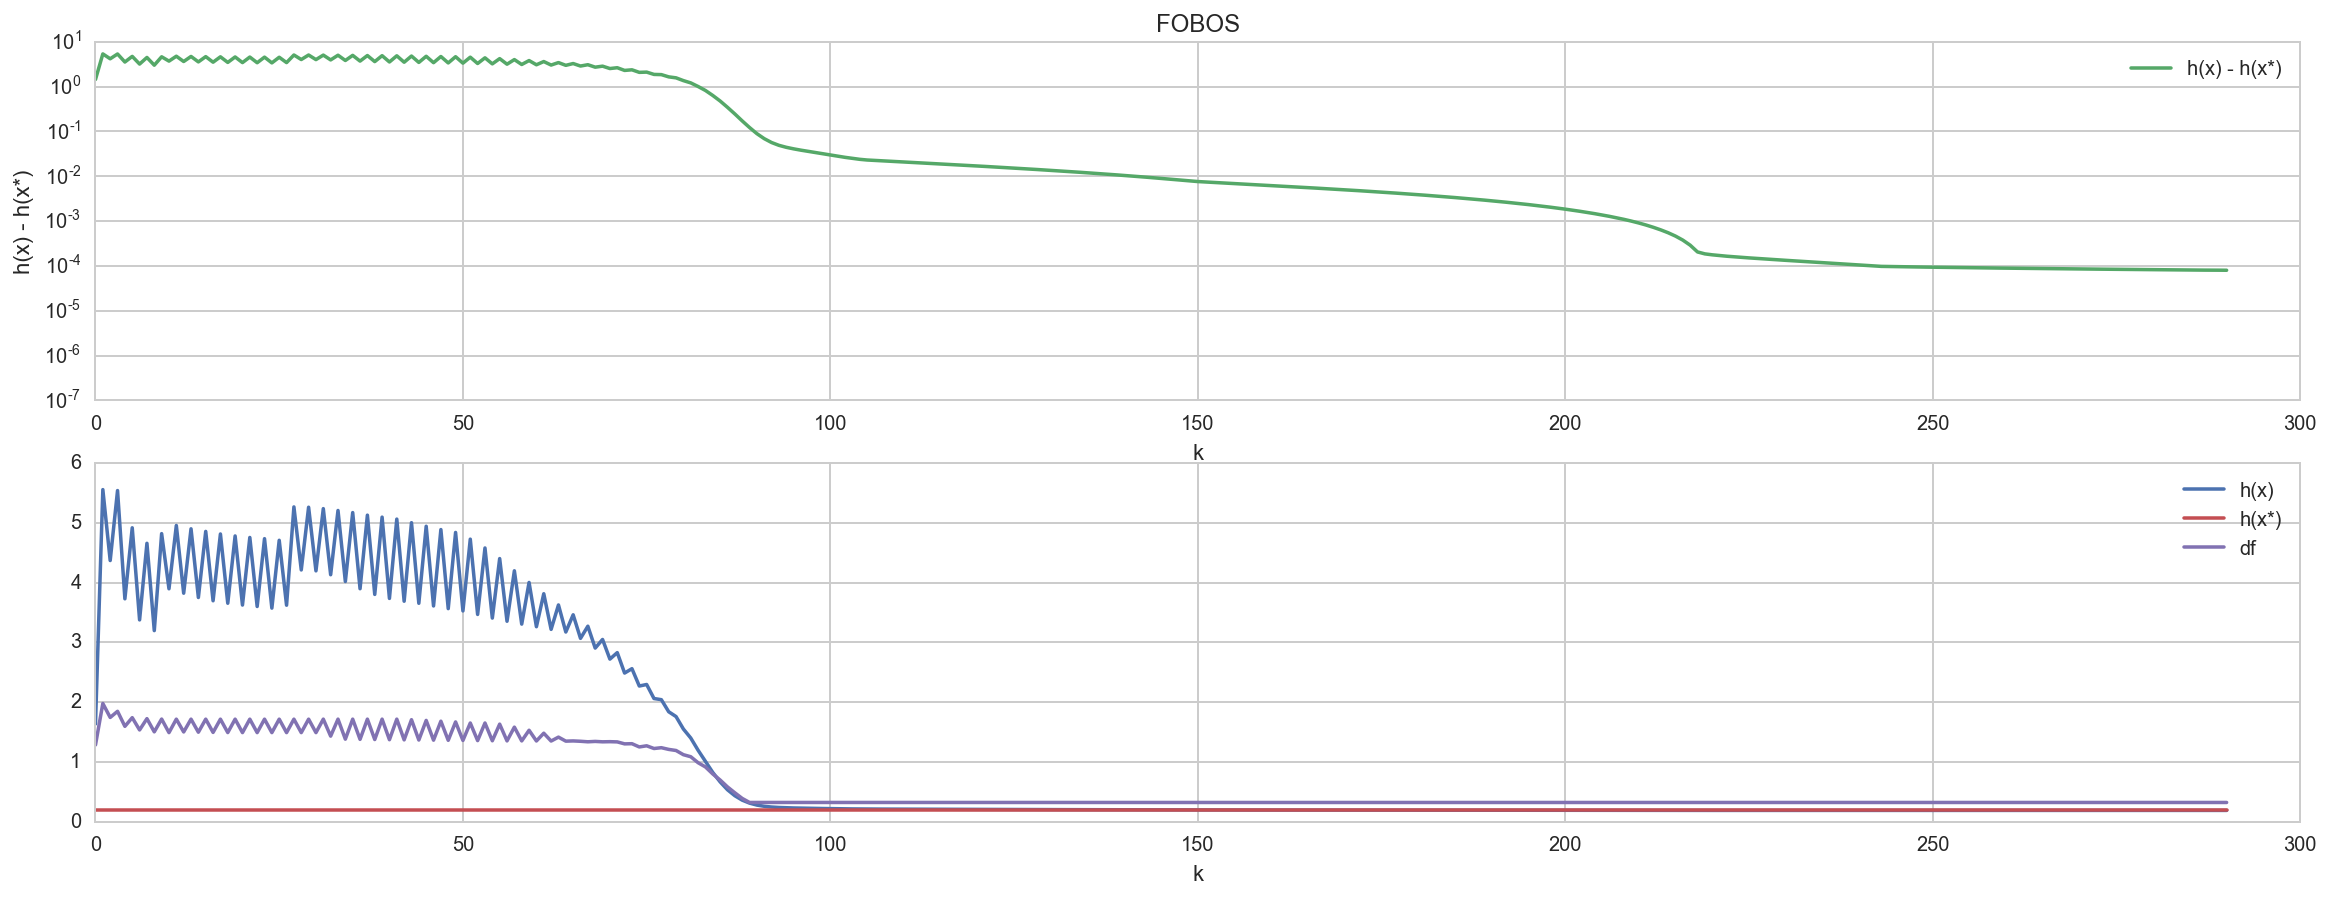

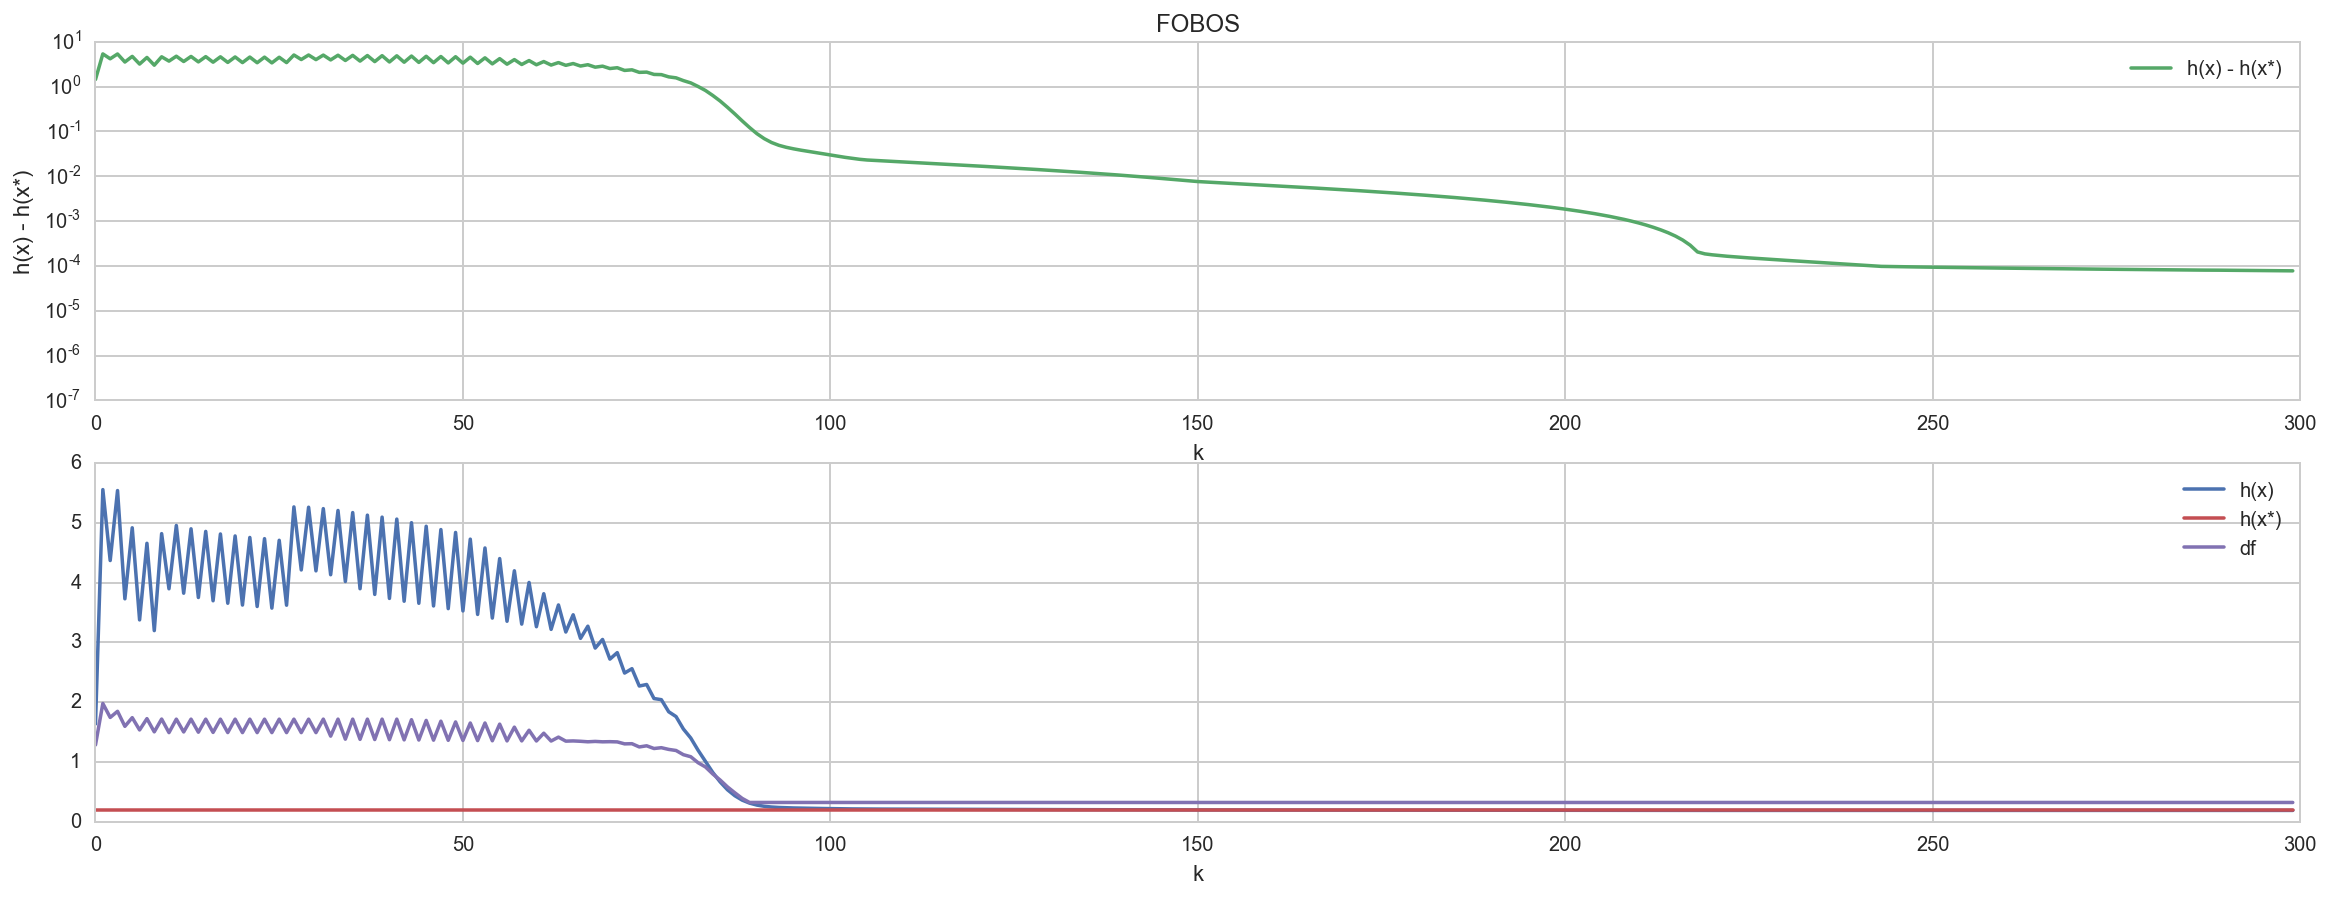

In [141]:
# initialize with a valid starting point
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

fobos_output = OptOutput("FOBOS", max_iteration,
                   ["k", "h(x)", "h(x) - h(x*)", "h(x*)", "df", "alpha"], label="h(x) - h(x*)")

for k in range(max_iteration):
    alpha = 1 / (k + 1)
    #alpha = 1e-2
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(prox_step, [(p_bats[bus.index] * xsol
                                          - alpha * grad_f(xsol, bus=bus),
                                          bus.index, alpha) for bus in buses_wo_slack])

    xpre = xsol.copy()
    xsol = sum([p_bats[i].T * step for i, step in enumerate(steps)])
        
    # Output
    fobos_output.update_values({"k" : k, "h(x)" : h(xsol), "h(x) - h(x*)" : h(xsol)- h(xstar),
                          "h(x*)" : h(xstar), "df" : norm(grad_f(xsol), ord=inf), "alpha": alpha})

#  Proximal Gradient

In [142]:
max_iteration = 300
ld = 0.8

| k|h(x)|h(x) - h(x*)|df|h(x*)|alpha|ld |
| ---|---|---|---|---|---|---|
| 0|4.79E-01|2.91E-01|5.79E-01|1.87E-01|0.00E+00|0.00E+00|
| 10|2.62E+00|2.43E+00|1.32E+00|1.87E-01|5.00E-02|8.00E-01|
| 20|2.22E+00|2.03E+00|1.08E+00|1.87E-01|2.50E-02|8.00E-01|
| 30|1.23E+00|1.04E+00|8.53E-01|1.87E-01|1.67E-02|8.00E-01|
| 40|2.49E-01|6.15E-02|3.18E-01|1.87E-01|1.25E-02|8.00E-01|
| 50|2.19E-01|3.17E-02|3.20E-01|1.87E-01|1.00E-02|8.00E-01|
| 60|2.04E-01|1.68E-02|3.20E-01|1.87E-01|8.33E-03|8.00E-01|
| 70|1.99E-01|1.15E-02|3.20E-01|1.87E-01|7.14E-03|8.00E-01|
| 80|1.96E-01|8.99E-03|3.20E-01|1.87E-01|6.25E-03|8.00E-01|
| 90|1.94E-01|6.93E-03|3.20E-01|1.87E-01|5.56E-03|8.00E-01|
| 100|1.92E-01|5.11E-03|3.20E-01|1.87E-01|5.00E-03|8.00E-01|
| 110|1.91E-01|3.82E-03|3.20E-01|1.87E-01|4.55E-03|8.00E-01|
| 120|1.90E-01|2.99E-03|3.20E-01|1.87E-01|4.17E-03|8.00E-01|
| 130|1.89E-01|2.25E-03|3.20E-01|1.87E-01|3.85E-03|8.00E-01|
| 140|1.89E-01|1.62E-03|3.20E-01|1.87E-01|3.57E-03|8.00E-01|
| 150|1.88E-01|1.06E-03|3.20E-01|1.87E-01|3.33E-03|8.00E-01|
| 160|1.88E-01|5.43E-04|3.20E-01|1.87E-01|3.13E-03|8.00E-01|
| 170|1.87E-01|2.74E-04|3.20E-01|1.87E-01|2.94E-03|8.00E-01|
| 180|1.87E-01|2.33E-04|3.20E-01|1.87E-01|2.78E-03|8.00E-01|
| 190|1.87E-01|2.06E-04|3.20E-01|1.87E-01|2.63E-03|8.00E-01|
| 200|1.87E-01|1.85E-04|3.20E-01|1.87E-01|2.50E-03|8.00E-01|
| 210|1.87E-01|1.75E-04|3.20E-01|1.87E-01|2.38E-03|8.00E-01|
| 220|1.87E-01|1.67E-04|3.20E-01|1.87E-01|2.27E-03|8.00E-01|
| 230|1.87E-01|1.60E-04|3.20E-01|1.87E-01|2.17E-03|8.00E-01|
| 240|1.87E-01|1.53E-04|3.20E-01|1.87E-01|2.08E-03|8.00E-01|
| 250|1.87E-01|1.48E-04|3.20E-01|1.87E-01|2.00E-03|8.00E-01|
| 260|1.87E-01|1.44E-04|3.20E-01|1.87E-01|1.92E-03|8.00E-01|
| 270|1.87E-01|1.40E-04|3.20E-01|1.87E-01|1.85E-03|8.00E-01|
| 280|1.87E-01|1.36E-04|3.20E-01|1.87E-01|1.79E-03|8.00E-01|
| 290|1.87E-01|1.33E-04|3.20E-01|1.87E-01|1.72E-03|8.00E-01|
| 300|1.87E-01|1.30E-04|3.20E-01|1.87E-01|1.67E-03|8.00E-01|


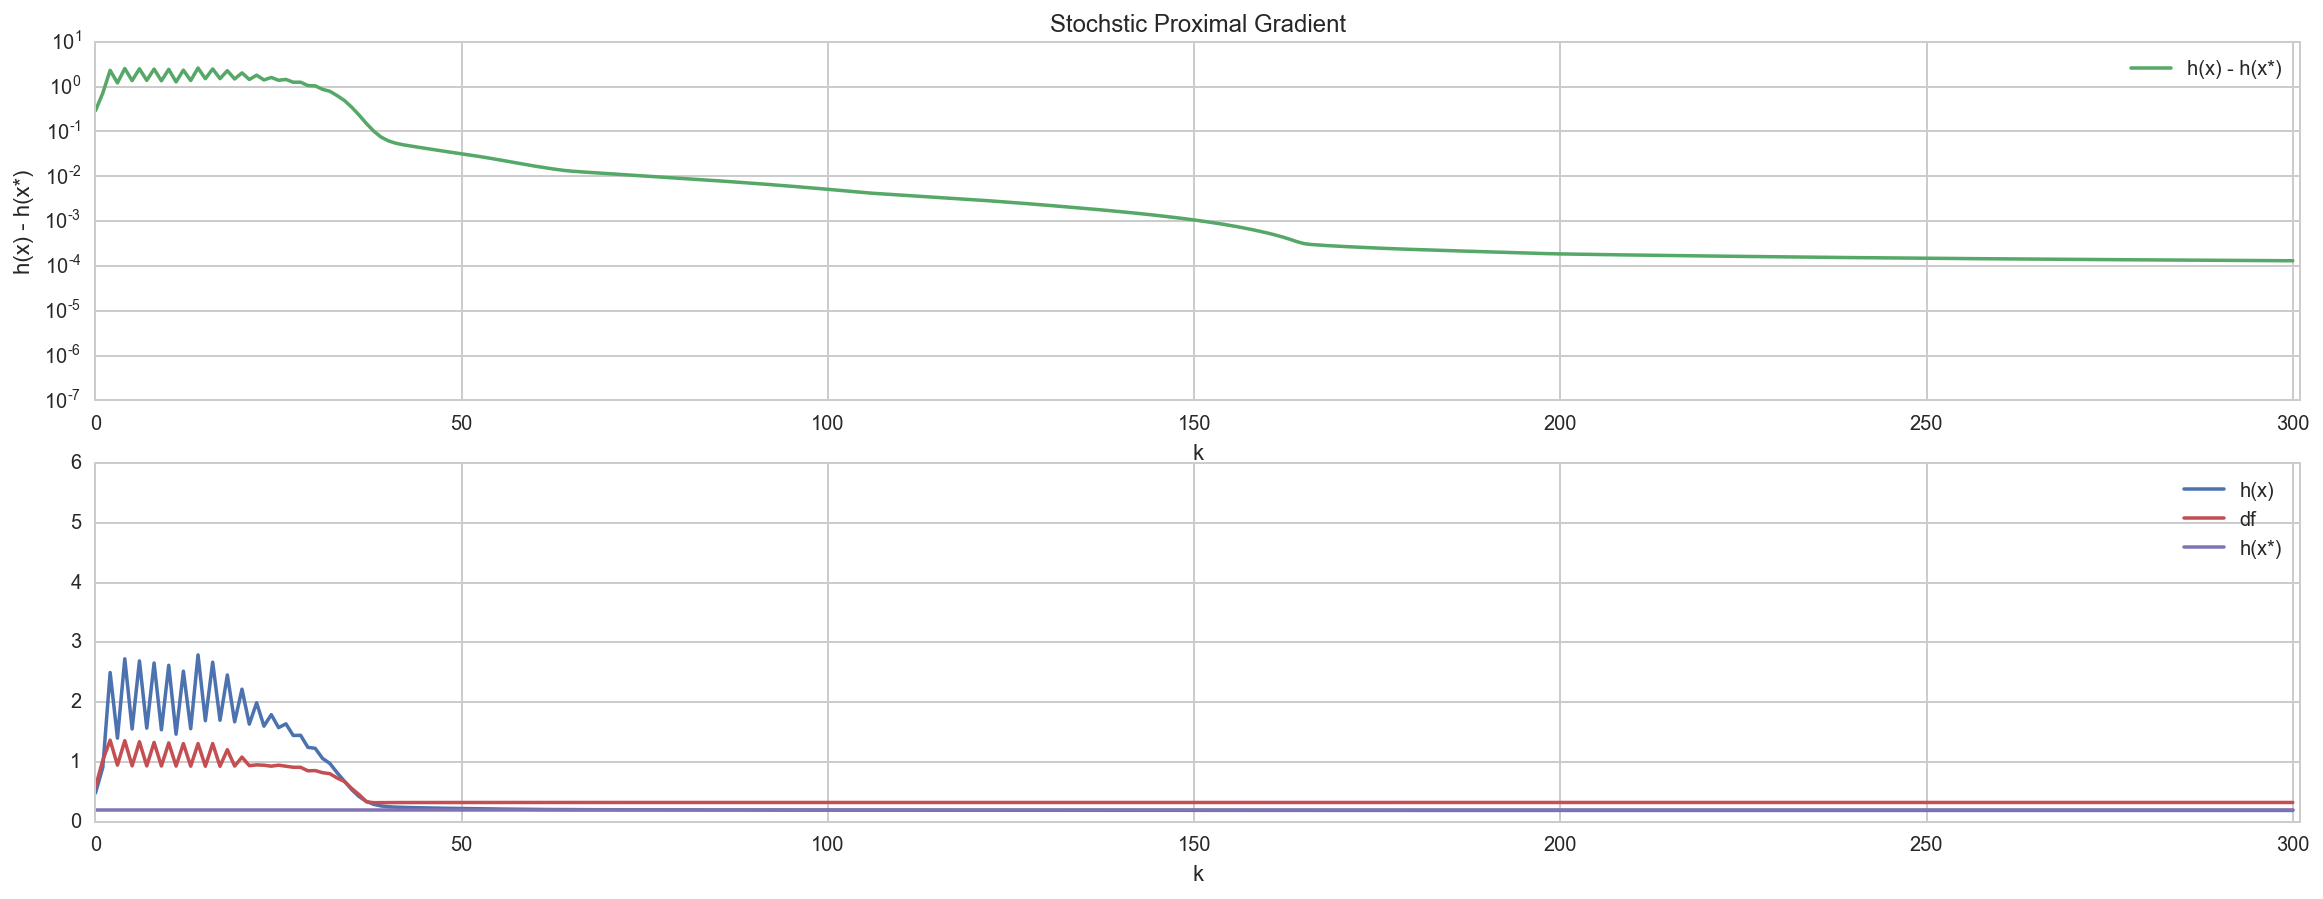

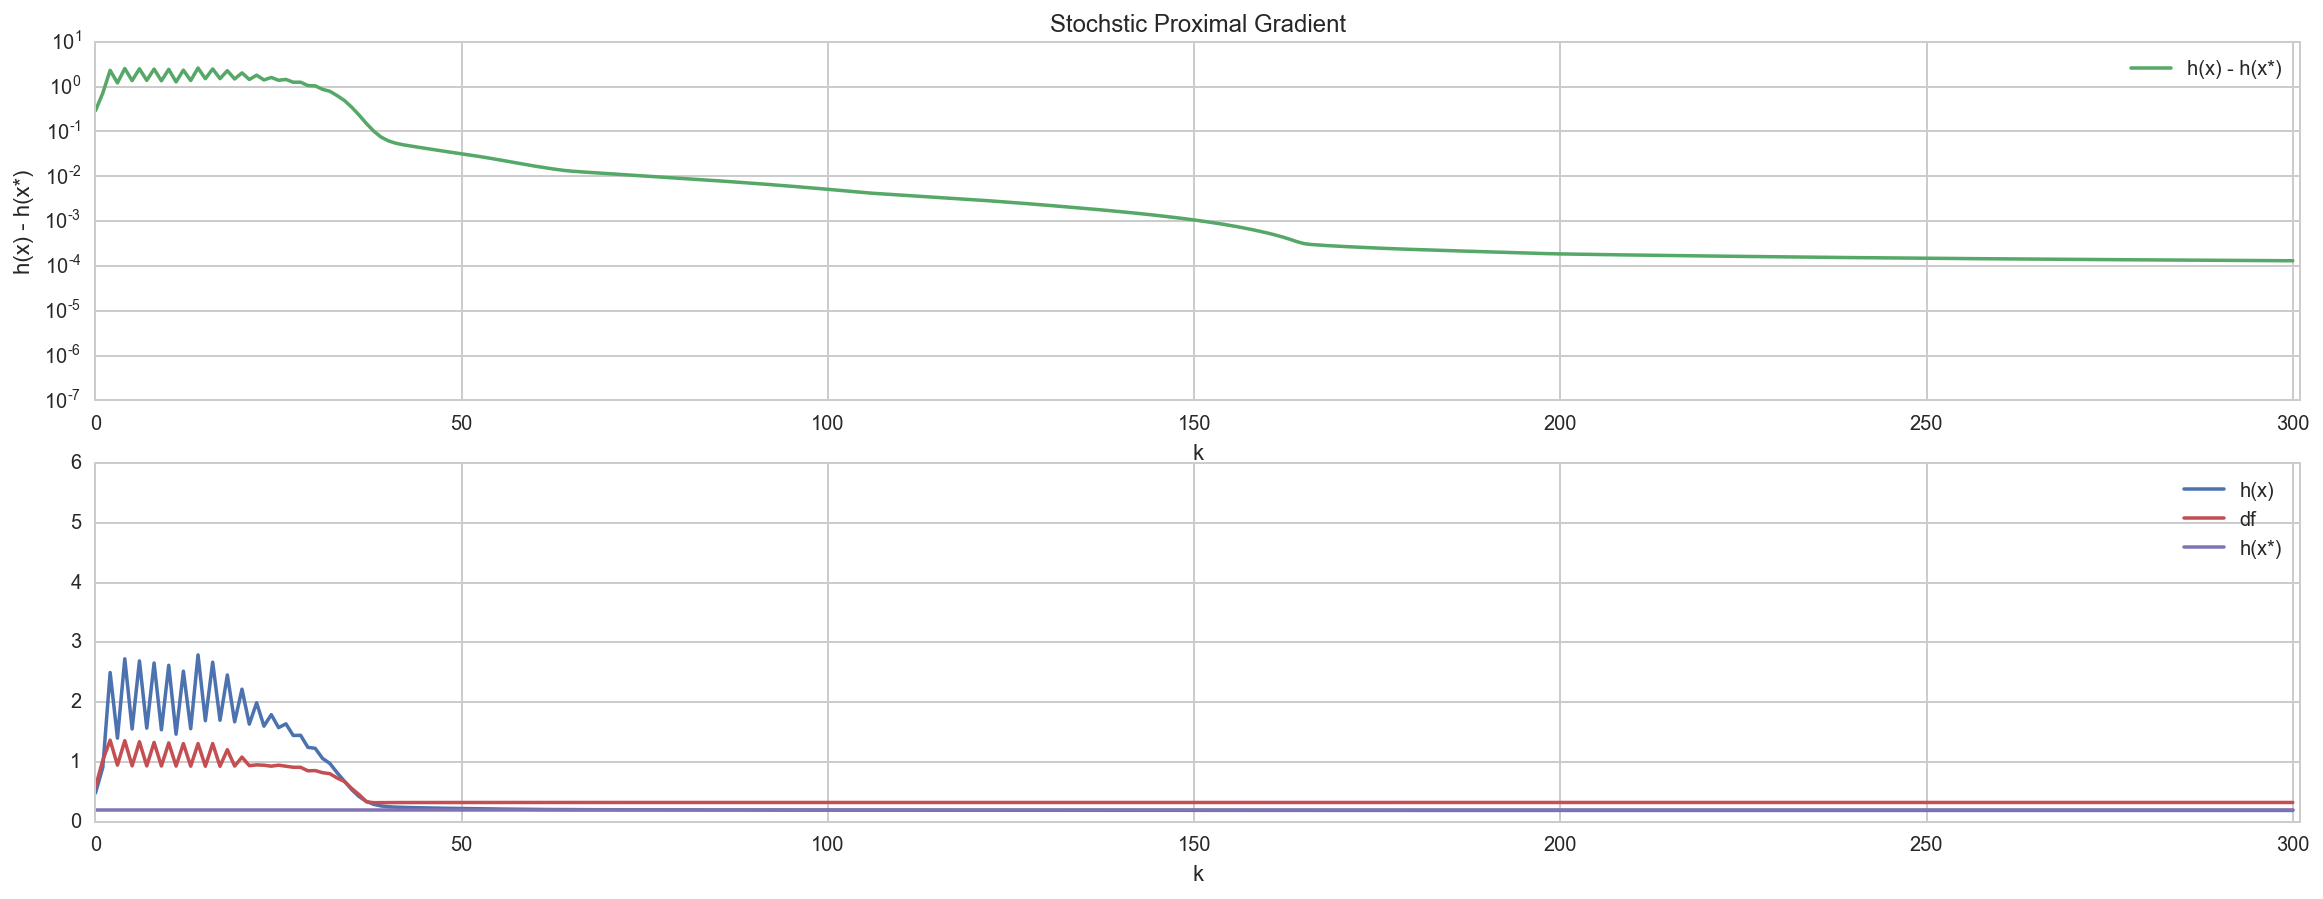

In [143]:
# initialize with a valid starting point
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

spg_output = OptOutput("Proximal Gradient", max_iteration + 1,
                   ["k", "h(x)", "h(x) - h(x*)", "df","h(x*)", "alpha", 'ld'], label="h(x) - h(x*)")
spg_output.update_values({"k" : 0, "h(x)" : h(xsol), "h(x) - h(x*)" : h(xsol)- h(xstar),
                          "df" : norm(grad_f(xsol), ord=inf), "h(x*)" : h(xstar), "alpha": 0.0,
                          "ld" : 0.0})
for iteration in range(max_iteration):
    alpha = 5e-1/(iteration + 1)
    #alpha = 1e-2
    
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(prox_step, [(p_bats[bus.index] * xsol - alpha * grad_f(xsol, bus=bus), bus.index, alpha) for bus in buses_wo_slack])

    xstep = sum([p_bats[i].T * step for i, step in enumerate(steps)])
        
    xpre = xsol.copy()
    # second step (averaging)
    xsol = (1-ld) * xpre + ld * xstep
    
    # Output
    spg_output.update_values({"k" : iteration + 1, "h(x)" : h(xsol), "h(x) - h(x*)" : h(xsol)- h(xstar),
                          "df" : norm(grad_f(xsol), ord=inf), "h(x*)" : h(xstar), "alpha": alpha,
                          "ld" : ld})

# Compare Alogrithms

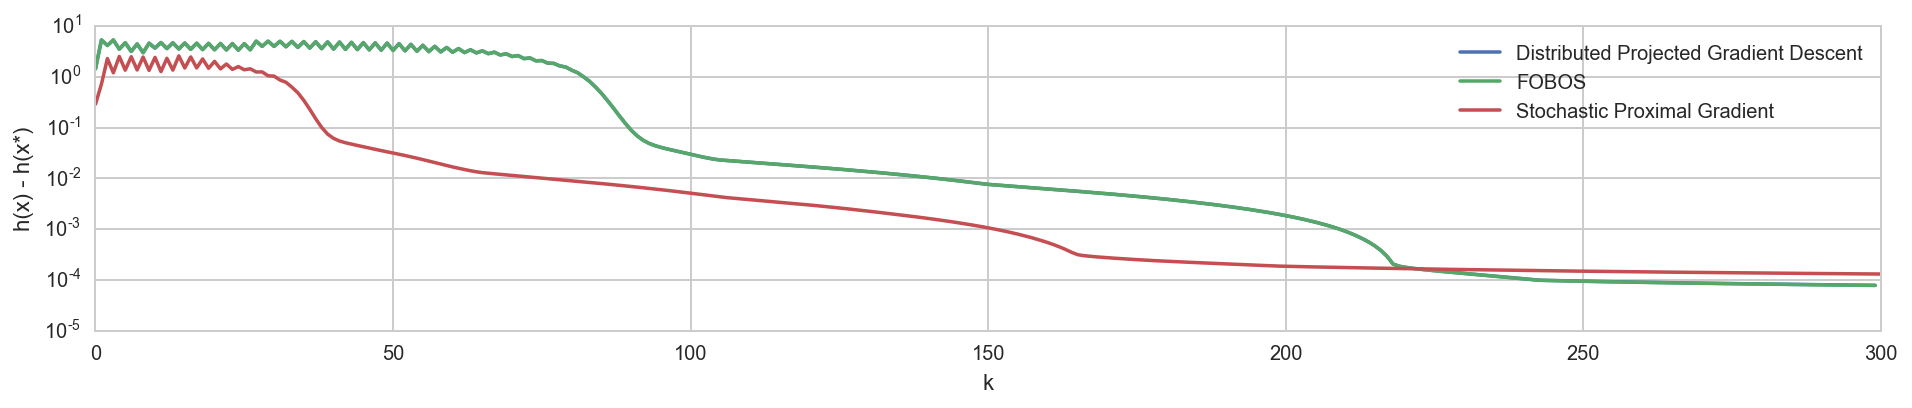

In [144]:
import matplotlib.pyplot as pyplot
fig = pyplot.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(dpg_output.values['h(x) - h(x*)'], label="Distributed Projected Gradient Descent")
ax.plot(fobos_output.values['h(x) - h(x*)'], label="FOBOS")
ax.plot(spg_output.values['h(x) - h(x*)'], label="Stochastic Proximal Gradient")
ax.set_yscale('log')
ylabel("h(x) - h(x*)")
xlabel("k")
legend()

# Stochstic Proximal Gradient

Laplacian Noise: $f(x; \mu, \lambda) = \frac{1}{2\lambda} \exp \left( - \frac{|x- \mu|}{\lambda} \right)$
 
Sensitivity: $\lambda = \frac{\Delta F}{\epsilon}$

In [147]:
epsilon = 1e-1
delta = 1e-7
L = 4 * pow(gamma, 2)  *norm((D_s.T* D_s) )
K = 200
lamd =( K * (K-1) * L * delta) / (2 * epsilon)
c = 8e-3
eta = 10

Nosiy Gradient of $h'(x)$ at bus $i$
$$ \Delta h'_i (x) = \gamma ( 2 d_c^\top D + 2 d_s(x)^\top D)+ w_k\\
= 2 \gamma ( d_c + d_s(x))^\top D  + w_k$$

In [148]:
( K * (K-1) * L * delta) / (2 * epsilon)

0.46414377082968594

In [149]:
def get_noisy_vector(k, shape):
    lamd =( K * (K-1) * L * delta) / (2 * epsilon)
    #lambd = 1e6
    if k == 0:
        noise = np.zeros(shape)
    else: 
        noise = np.random.laplace(loc=0, scale=lamd, size=shape)
    return noise

In [150]:
def noisy_grad_f(xsol, bus, iteration):
    p_k = grad_f(xsol, bus=bus)
    w_k = get_noisy_vector(iteration, p_k.shape) #+1/ (2* lamd)
    return p_k + w_k

| k|h(x)|h(x) - h(x*)|df|alpha|theta |
| ---|---|---|---|---|---|
| 0|4.79E-01|2.91E-01|5.79E-01|0.00E+00|0.00E+00|
| 10|1.91E+00|1.73E+00|3.58E-01|5.00E-02|8.00E-01|
| 20|1.80E+00|1.61E+00|2.67E-01|2.50E-02|8.00E-01|
| 30|1.75E+00|1.56E+00|3.33E-01|1.67E-02|8.00E-01|
| 40|1.73E+00|1.55E+00|3.24E-01|1.25E-02|8.00E-01|
| 50|1.65E+00|1.46E+00|2.57E-01|1.00E-02|8.00E-01|
| 60|1.59E+00|1.40E+00|2.38E-01|8.33E-03|8.00E-01|
| 70|1.53E+00|1.34E+00|2.42E-01|7.14E-03|8.00E-01|
| 80|1.49E+00|1.30E+00|2.53E-01|6.25E-03|8.00E-01|
| 90|1.44E+00|1.26E+00|2.29E-01|5.56E-03|8.00E-01|
| 100|1.42E+00|1.23E+00|2.26E-01|5.00E-03|8.00E-01|
| 110|1.40E+00|1.21E+00|2.30E-01|4.55E-03|8.00E-01|
| 120|1.36E+00|1.17E+00|2.51E-01|4.17E-03|8.00E-01|
| 130|1.32E+00|1.13E+00|2.11E-01|3.85E-03|8.00E-01|
| 140|1.31E+00|1.12E+00|2.18E-01|3.57E-03|8.00E-01|
| 150|1.29E+00|1.11E+00|2.01E-01|3.33E-03|8.00E-01|
| 160|1.27E+00|1.08E+00|2.19E-01|3.13E-03|8.00E-01|
| 170|1.26E+00|1.07E+00|2.23E-01|2.94E-03|8.00E-01|
| 180|1.23E+00|1.05E+00|2.19E-01|2.78E-03|8.00E-01|
| 190|1.23E+00|1.05E+00|2.19E-01|2.63E-03|8.00E-01|
| 200|1.23E+00|1.04E+00|2.38E-01|2.50E-03|8.00E-01|


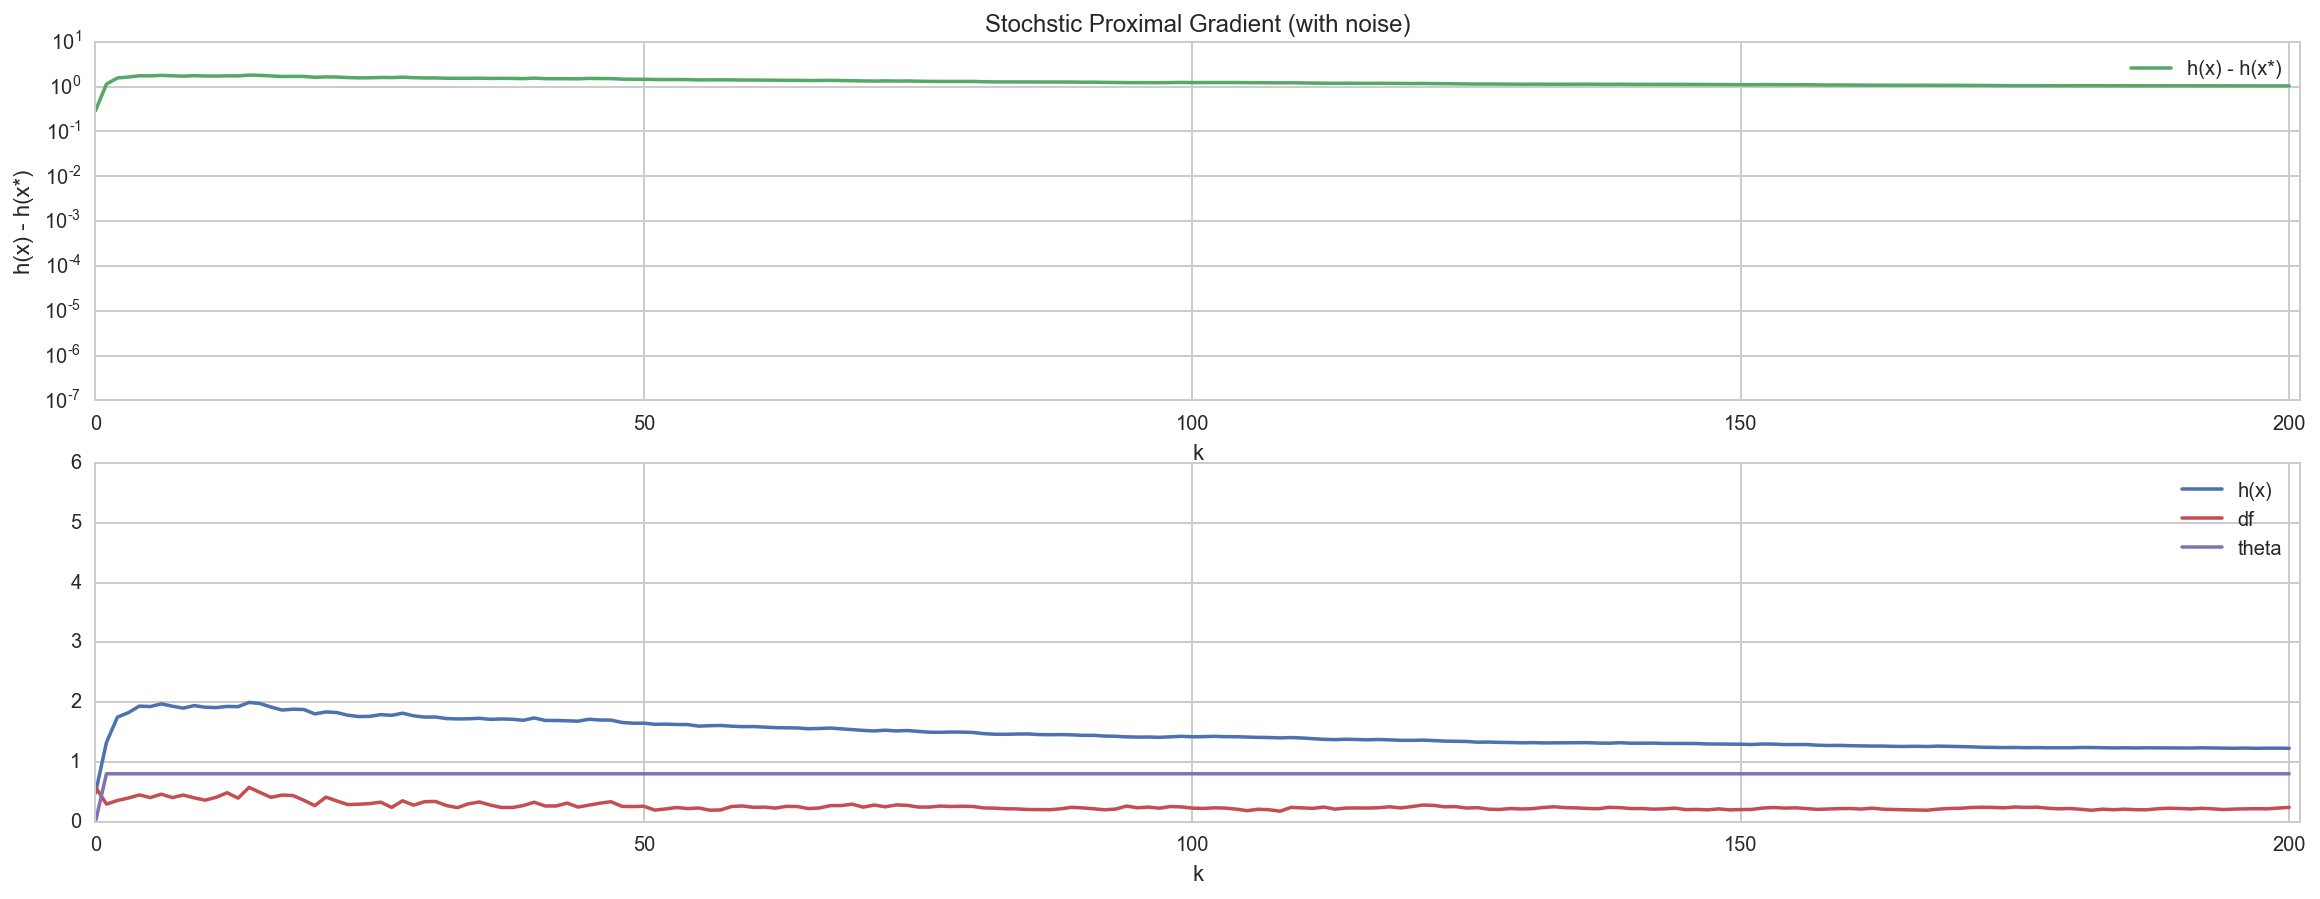

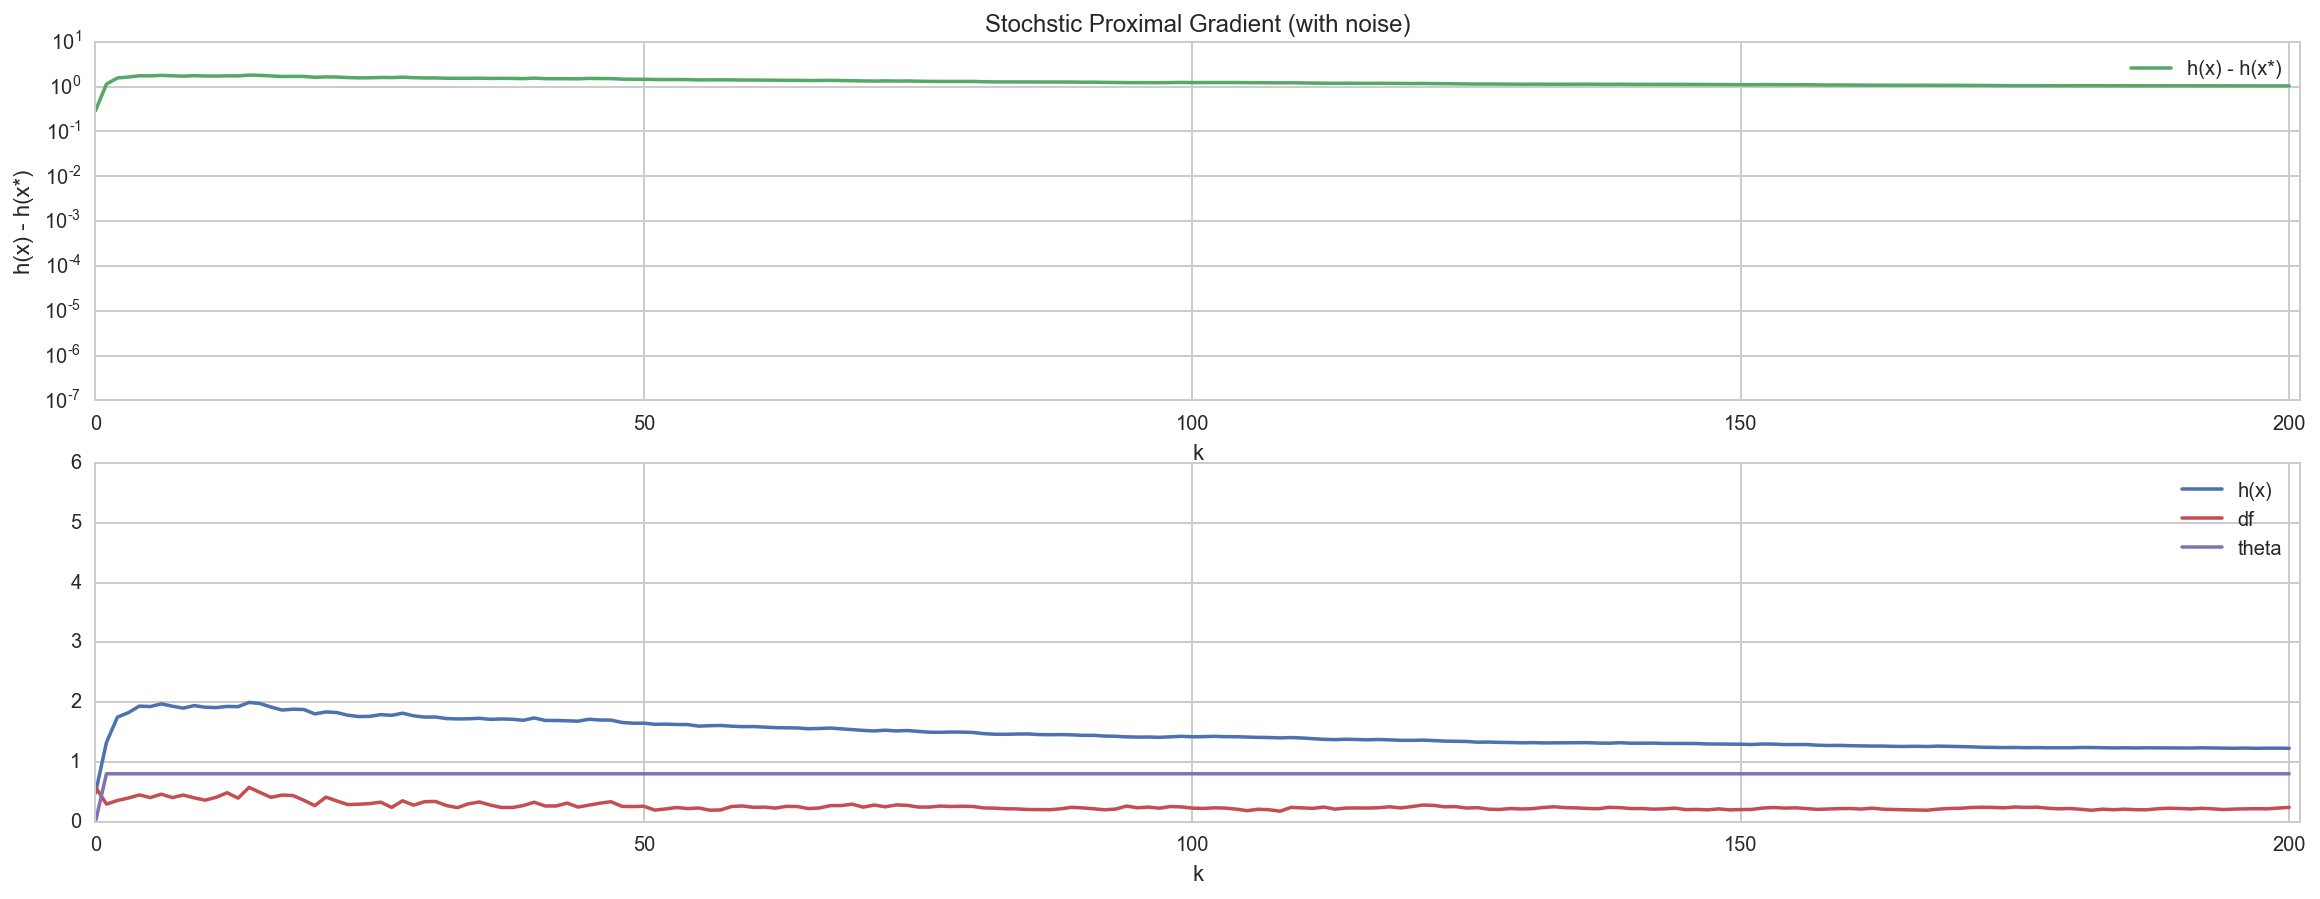

In [151]:
# initialize with a valid starting point
xsol = global_proj_x(np.zeros((len(xstar),)))
buses_wo_slack = list(filter(lambda bus: (not bus.is_slack()), mp.get_network().buses))

nspg_output = OptOutput("Stochstic Proximal Gradient", K + 1,
                   ["k", "h(x)", "h(x) - h(x*)", "df", "alpha", 'theta'], label="h(x) - h(x*)")

nspg_output.update_values({"k" : 0, "h(x)" : h(xsol), "h(x) - h(x*)" : h(xsol)- h(xstar),
                          "df" : norm(grad_f(xsol), ord=inf), "alpha": 0.0, "theta" : 0.0})
for k in range(K):
    alpha = 5e-1/(k + 1)    
    #alpha = c/np.sqrt(k + 1) 
    #alpha = 1.0E-4
    
    #theta = (eta + 1) / (eta + k)
    theta = 0.8
    
    with multiprocessing.Pool() as pool:
        steps = pool.starmap(prox_step, [(p_bats[bus.index] * xsol 
                                          - alpha * noisy_grad_f(xsol, bus, iteration),
                                          bus.index, alpha)
                                         for bus in buses_wo_slack])

    xstep = sum(p_bats[i].T * step for i, step in enumerate(steps))
    xpre = xsol.copy()
    
    # averaging step
    xsol = (1-theta) * xpre + theta * xstep
    
    # Output
    nspg_output.update_values({"k" : k +1, "h(x)" : h(xsol), "h(x) - h(x*)" : h(xsol)- h(xstar),
                          "df" : norm(grad_f(xsol), ord=inf), "alpha": alpha, "theta" : theta})

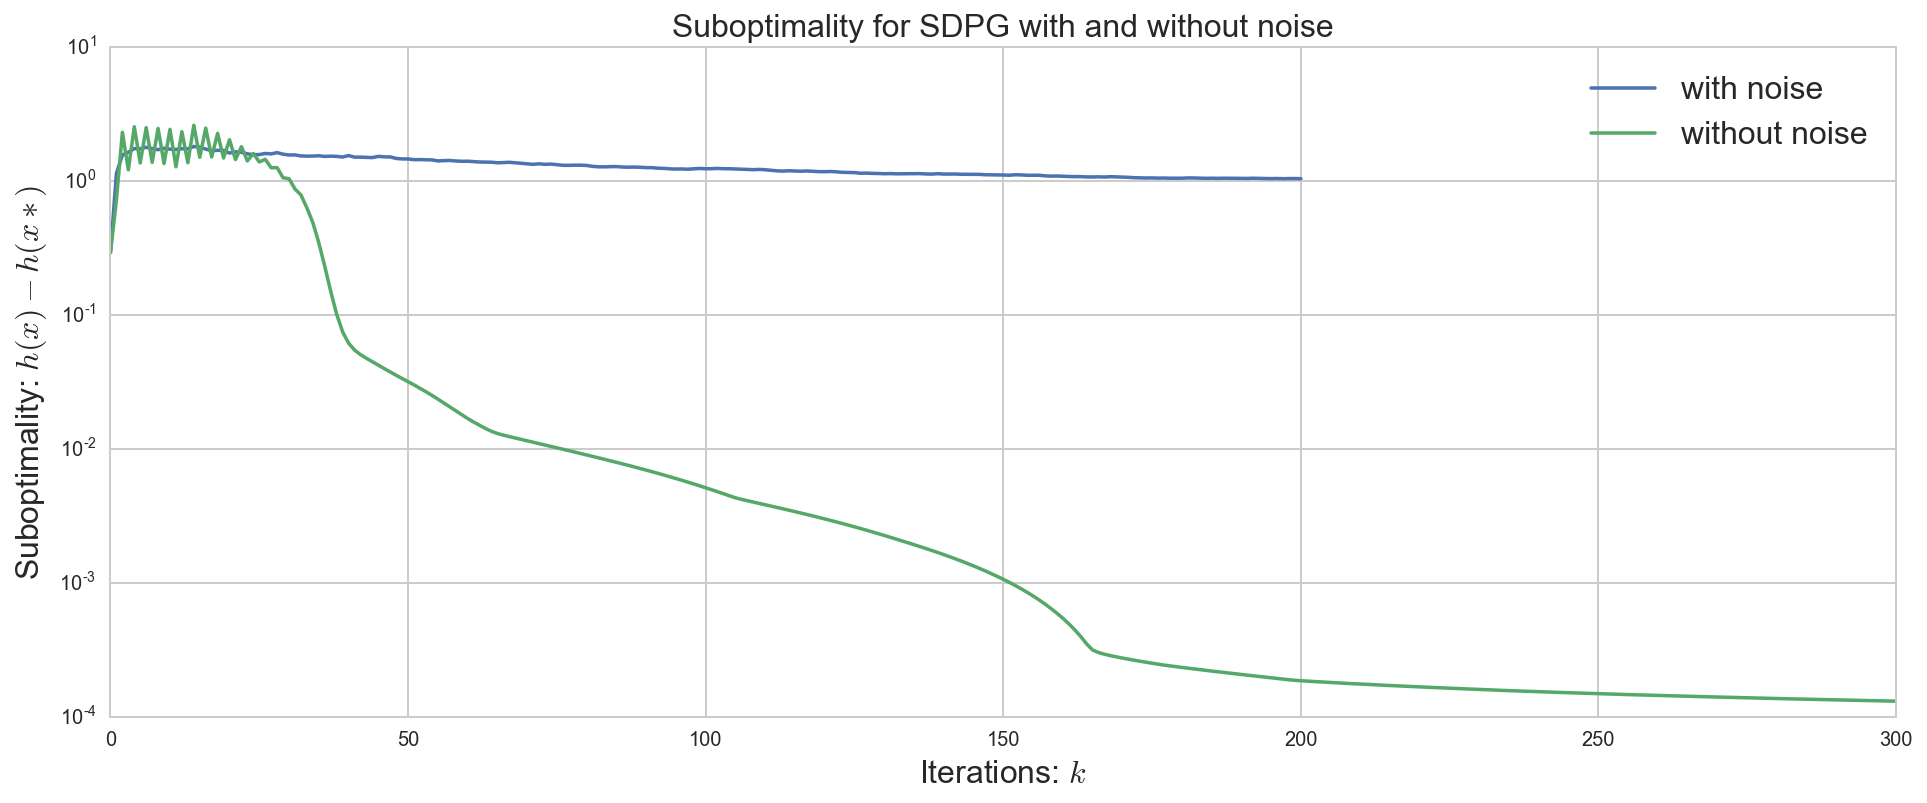

In [152]:
from matplotlib.pyplot import savefig, gca
plot(nspg_output.values['h(x) - h(x*)'], label="with noise")
plot(spg_output.values['h(x) - h(x*)'], label="without noise")
ylabel("Suboptimality: $h(x) - h(x*)$", fontsize=16)
xlabel("Iterations: $k$", fontsize=16)
title("Suboptimality for SDPG with and without noise", fontsize=16)
legend(prop={'size':16})
ax = gca()
ax.set_yscale('log')
savefig('suboptimality-4.pdf')

# Numeric Sensitivity Computation

In [153]:
c = dict()
for bus_i in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    i = bus_i.index
    c[i] = np.matrix(np.fromiter((constant_powers[t, i] for t in range(mp.timesteps)), dtype=float)).T

In [199]:
def grad_f_p(x, p_dist=np.zeros(mp.timesteps), d_xi = None):
    if d_xi is None:
        d_xi = sum([c[bus.index] for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)]).A.flatten()
    return gamma* (2 * (D_s.T * D_c).dot(d_xi + p_dist).A.flatten() + 2 * (D_s.T.dot(d_s(x))).A.flatten())

In [198]:
Dtilde = 2 * alpha * gamma * D_s.T * D_c

## Sensitivity by bounding $H$

In [158]:
bus_id = 1
xbar = p_bats[bus_id] * xsol
x_s = cvxpy.Variable(len(xbar))
proj_obj = cvxpy.Minimize(0.5 * cvxpy.sum_squares(x_s - xbar) + alpha * g_mats[i] * x_s)
proj_constr = [l_mats[i] <= x_s, x_s <= u_mats[i], a_bats[i] * x_s == b_bats[i]]
proj_prob = cvxpy.Problem(proj_obj, proj_constr)
proj_prob.solve()
dual_eq = proj_prob.constraints[2].dual_value
dual_lower = proj_prob.constraints[0].dual_value
dual_upper = proj_prob.constraints[1].dual_value

In [200]:
nx = 72
bus_id = 1
lambd = dual_lower.A.flatten()
mu = dual_upper.A.flatten()

x = x_s.value.A.flatten()

d_lamdb = scipy.sparse.diags(lambd)
d_mu = scipy.sparse.diags(mu)
d_xu = scipy.sparse.diags(x - u_mats[bus_id])
d_xl = scipy.sparse.diags(l_mats[bus_id] - x)


H = scipy.sparse.bmat([[scipy.sparse.eye(nx), - scipy.sparse.eye(nx),  scipy.sparse.eye(nx), a_bats[bus_id].T],
                    [a_bats[bus_id], None, None, None],
                    [- d_lamdb, d_xl, None, None],
                      [d_mu, None, d_xu, None]]).tocsc()

d = scipy.sparse.vstack([Dtilde, scipy.sparse.coo_matrix((2 * nx + a_bats[0].shape[0], Dtilde.shape[1]))]).tocsc()

Condition Number:

In [160]:
"{:.2E}".format(np.linalg.cond(H.toarray()))

'2.26E+05'

$||H^{-1}||_2$

In [161]:
print("{:.2E}".format(1 / np.linalg.norm(H.toarray(), ord=-2)))

7.05E+04


## Sensitivity by random sampling the projection operator

lower and upper bound on the randomly generated load profile

In [180]:
high_load = 1.5
low_load = -0.6

32: 1.86E-02 

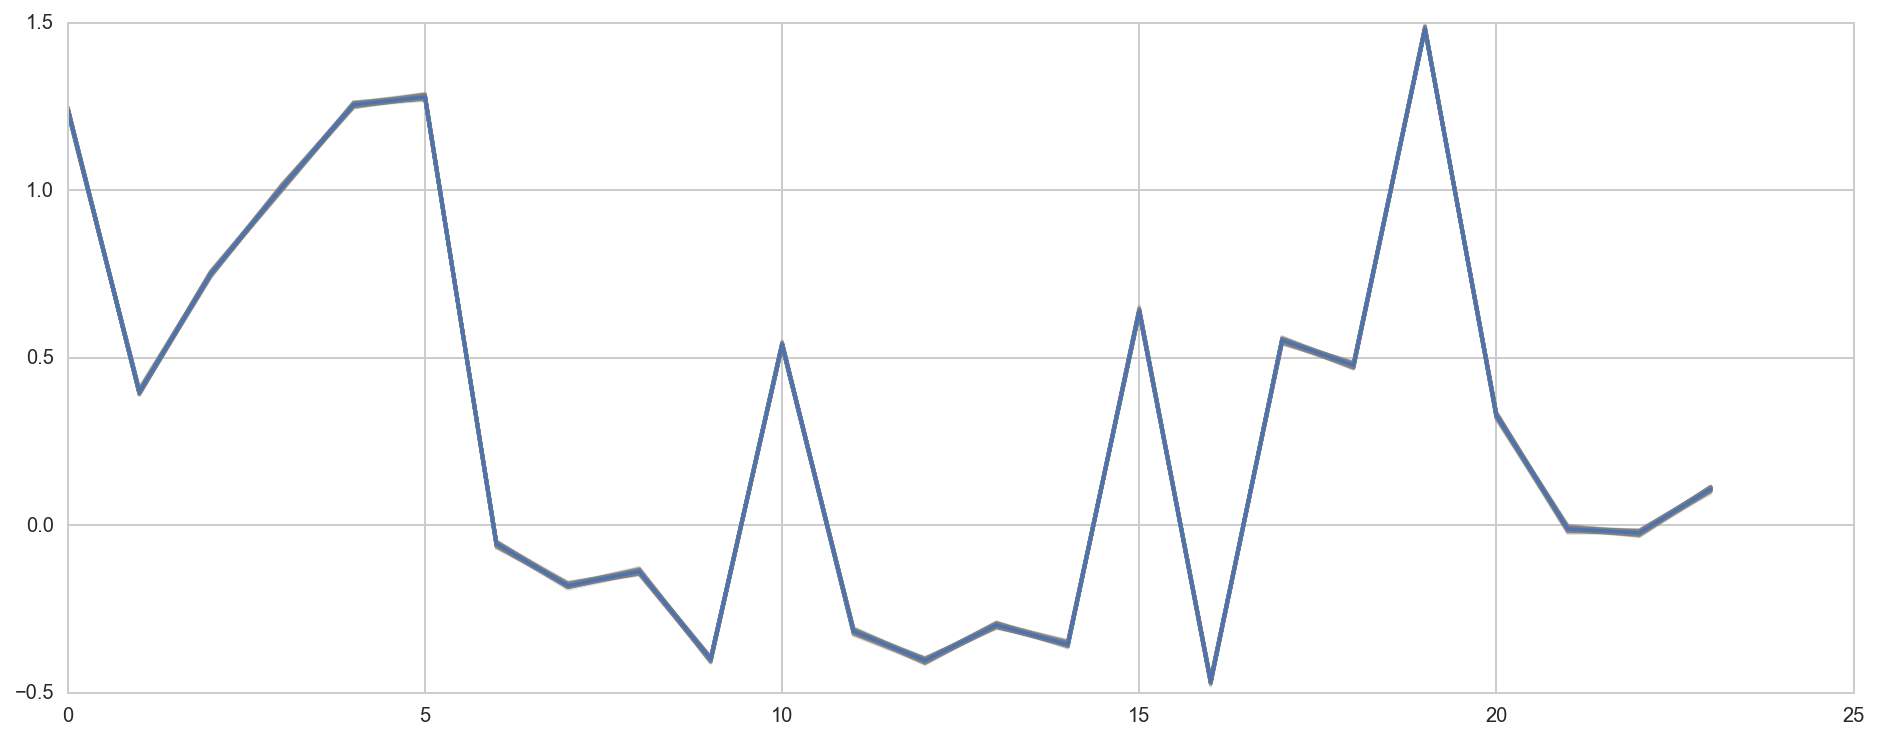

KeyboardInterrupt: 

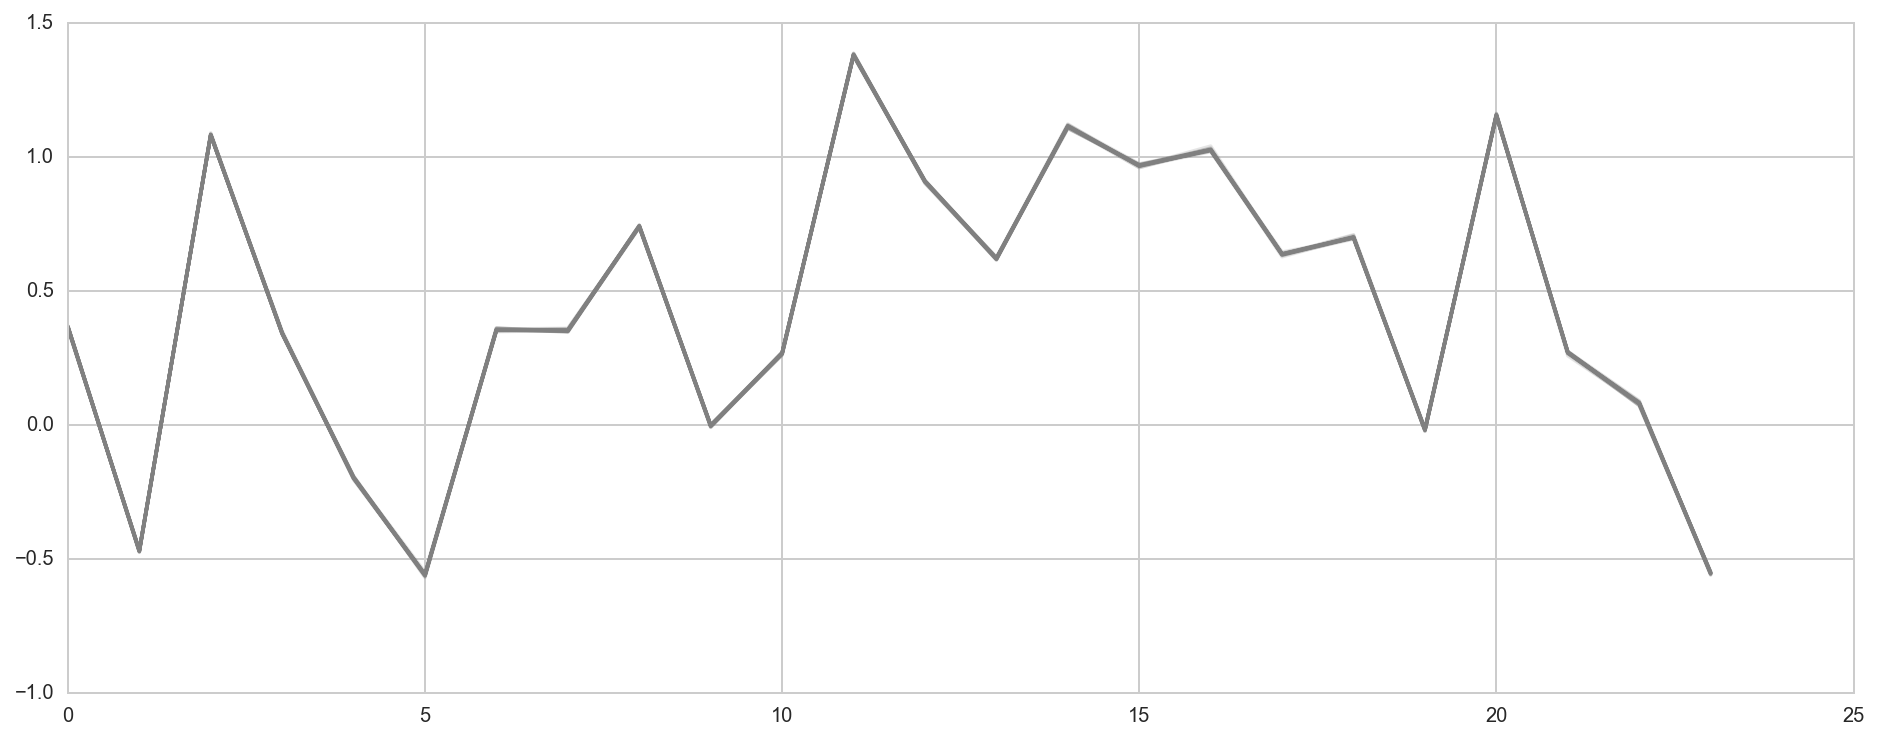

In [201]:
sensitivies = []
for i in range(200):
    # take a random sample for the starting point y
    x_sample = (p.u - p.l) * np.random.random_sample(size=p.u.shape[0]) + p.l
    
    # generate a random load profile
    d_xi = np.array((high_load - low_load) * np.random.sample(size=D_c.shape[1]) + low_load)
    
    # sample different adjacent vectors
    for n in range(200):
        # random direction
        p_rand = np.random.randn(len(d_xi))
        # random step
        alpha_rand = epsilon * np.random.random() 
        # random change in load profile that fulfils the adjacency relation
        p_dist = alpha_rand * (p_rand / np.linalg.norm(p_rand, ord=1))
        
        x_cur = p_bats[bus_id] * x_sample - alpha * grad_f_p(x_sample, d_xi=d_xi)        
        x_cur_prime = p_bats[bus.index] * x_sample - alpha * grad_f_p(x_sample, p_dist, d_xi=d_xi)
        
        # calculate sensitivity of the projection
        sensitivies.append(norm(prox_step(x_cur, 1, eta) - prox_step(x_cur_prime, 1, eta)))
        
        # plot the current load profile
        plot(d_xi + p_dist, color="grey", alpha=0.2)

    clear_output(wait=True)
    print("{}: {:.2E}".format(i, max(sensitivies)), end=" ")    
    plot(d_xi)
    show()
    

Calulcated sesitivity: {{ "{:.2E}".format(max(sensitivies))}}

In [171]:
Dotilde = D_s.T * D_c
Dutilde = D_s.T * D_s

In [208]:
n = net.num_buses
K

200

In [214]:
abs(2 * gamma) * norm(Dotilde, ord=1) 

8.0